# Analysis
Created by Ivan Lima on 2020-04-07 20:11:35 

In this notebook we examine gender differences in NSF Ocean Sciences awards between 1987 and 2019. The metrics we use for gender discrepancies are the annual percentage of female PIs and co-PIs in the awards. We track those metrics across: 

1. All NSF-OCE awards.
2. Awards from the top 10 largest NSF programs (in number of awards).
3. Across the top 10 academic organizations (in number of awards).
4. Identified research topics.
5. Award types

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import datetime, warnings
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Mon Jul 10 18:15:05 2023


In [2]:
warnings.filterwarnings('ignore')
# sns.set_theme(context='paper', style='ticks', palette='tab10', rc={'figure.dpi':100, 'axes.grid':True})
import sns_settings
pd.options.display.max_columns = 30

Read NSF-OCE award data.

In [3]:
data_types = {'Abstract':'string', 'Title':'string', 'Programs':'string', 'PI':'string',
              'Organization':'string', 'State':'string', 'Instrument':'string', 'co-PIs':'string',
              'program':'string', 'PI_first_name':'string', 'co-PI_first_name':'string',
              'PI_gender':'string', 'co-PI_gender':'string', 'award_type':'string'}
awards = pd.read_csv('results/awards_1985-2020_clean_edited_grouped_gender_topic.csv', index_col=0,
                     parse_dates=[4,5], dtype=data_types)
awards['year'] = awards.StartDate.dt.year
awards.loc[awards.program=='DATA NOT AVAILABLE','program'] = np.nan
awards['co-PI_female_pct'] = awards['co-PI_female_frac'] * 100

periods = np.array([[y,]*3 for y in range(1989,2021,3)]).flatten() # 3-year periods
years = np.arange(1987,2020)
year_to_period = {y:p for y,p in zip(years,periods)}
awards['period'] = awards.year.map(year_to_period) # map year to period

topic_probs = pd.read_csv('results/topic_probs.csv', index_col=0)
topic_words = pd.read_csv('results/topic_words.csv', index_col=0)

npzfile = np.load('results/NMF_TSNE.npz')
feature_names  = npzfile['feature_names']
nmf_components = npzfile['nmf_components']
topic_names    = npzfile['topic_names']
topic_names_r  = npzfile['topic_names_r']
X_tsne         = npzfile['X_tsne']
npzfile.close()

# Read geosciences/atmospheric/ocean sciences academic gender workforce data
workforce = pd.read_csv('data/nsf_workforce.csv')#, index_col=0)
workforce['female_frac'] = workforce.female/workforce.total
workforce['female_pct'] = workforce['female_frac'] * 100
workforce = workforce.set_index('year')

## All NSF-OCE awards

The figure below shows the number of awards and the amount awarded by NSF Ocean Sciences per year, and a box plot of the amount awarded to individual projects in each year between 1987 and 2019.

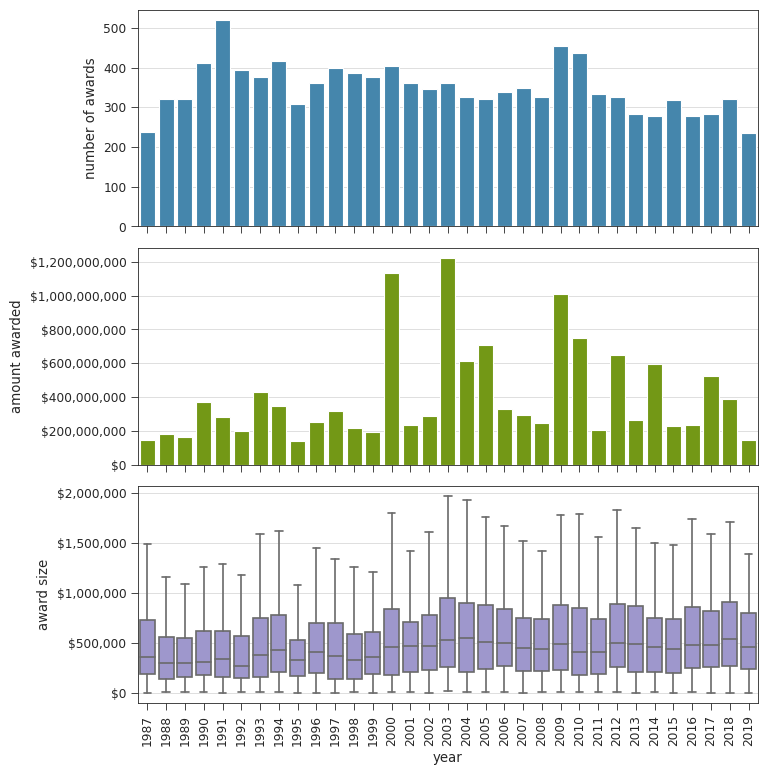

In [4]:
from matplotlib import ticker
def dollar(x, pos):
    return '${:,.0f}'.format(x)
fmt = ticker.FuncFormatter(dollar)

df_per_year = pd.DataFrame({'number':awards.groupby('year')['Abstract'].count(),
                            'amount':awards.groupby('year')['tot_amount_adjusted'].sum()})

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8,9))
fig.subplots_adjust(hspace=0.1)
_ = sns.barplot(data=df_per_year, x=df_per_year.index, y='number', color='C0', ax=axs[0])
_ = sns.barplot(data=df_per_year, x=df_per_year.index, y='amount', color='C2', ax=axs[1])
_ = sns.boxplot(data=awards, x='year', y='tot_amount_adjusted', color='C3', showfliers=False, ax=axs[2])
_ = axs[2].set_xticklabels(df_per_year.index, rotation=90)
_ = axs[0].set(ylabel='number of awards')
_ = axs[1].set(ylabel='amount awarded')
_ = axs[2].set(ylabel='award size')
for n in range(1,3):
    _ = axs[n].yaxis.set_major_formatter(fmt)

for n in range(0,2):
    _ = axs[n].set(xlabel='')

### Award size by PI gender

Statistics of the individual awards received by male and female PIs.

In [5]:
awards_male = awards[awards.PI_gender == 'male'][['year','tot_amount_adjusted']]
awards_female = awards[awards.PI_gender == 'female'][['year','tot_amount_adjusted']]

stats = pd.DataFrame({'male PIs': awards_male.tot_amount_adjusted.describe(),
                      'female PIs':awards_female.tot_amount_adjusted.describe()})
stats

male PIs    female PIs
count  9.271000e+03  2.146000e+03
mean   1.186963e+06  1.047491e+06
std    1.221179e+07  1.539015e+07
min    0.000000e+00  0.000000e+00
25%    1.974344e+05  1.820283e+05
50%    4.218187e+05  4.111775e+05
75%    7.603440e+05  7.341902e+05
max    8.472425e+08  7.019176e+08

Box plot of the amount awarded (award size) to individual projects by male and female PIs. Median and inter-quartile range seem to be about the same. The t-test for equal means shows that thedifference between the mean award size for male and female PIs is not statistically significant.  

T-test for equal means: t=0.392, p=0.695, df=2802


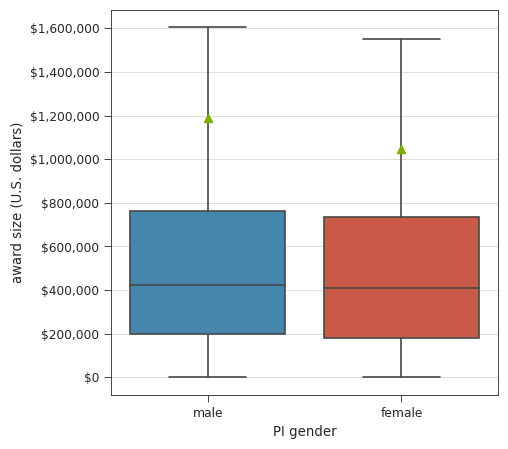

In [6]:
fig, ax = plt.subplots()
_ = sns.boxplot(data=awards, x='PI_gender', y='tot_amount_adjusted', showfliers=False, showmeans=True, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(xlabel='PI gender', ylabel='award size (U.S. dollars)')

male = awards_male.tot_amount_adjusted.values
female = awards_female.tot_amount_adjusted.values
tstat, pval, df = sm.stats.ttest_ind(male, female, usevar='unequal')
print('T-test for equal means: t={:.3f}, p={:.3f}, df={:.0f}'.format(tstat, pval, df))

Probability density plot of award size by PI gender. The distribution for male and female PIs is virtually identical.

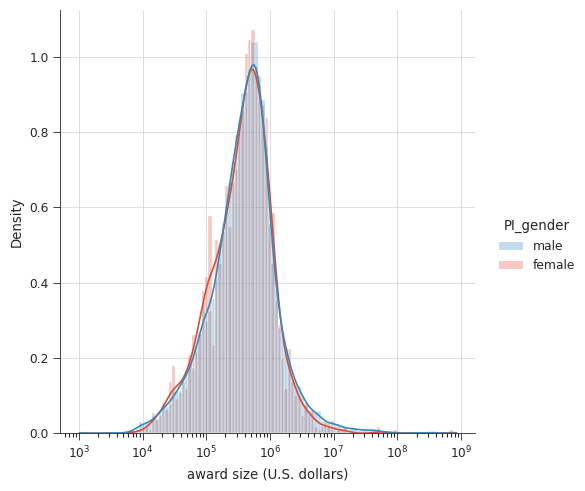

In [7]:
df = awards[awards.tot_amount_adjusted>1000]
g = sns.displot(df, x='tot_amount_adjusted', log_scale=True, hue='PI_gender', stat='density', common_norm=False, alpha=0.3, kde=True)#, element='step')
_ = g.set_xlabels('award size (U.S. dollars)')

Box plot of the amount awarded to individual projects by male and female PIs in each year.

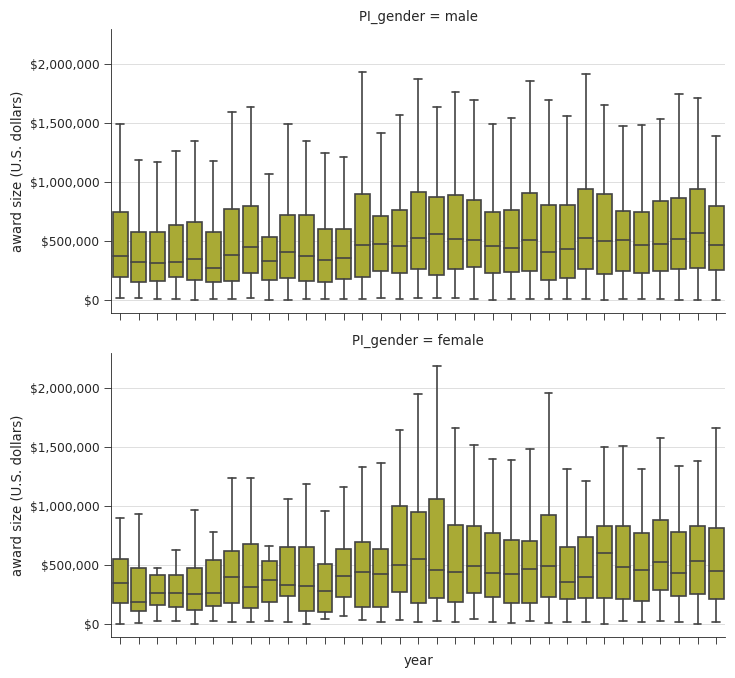

In [8]:
g = sns.catplot(data=awards, x='year', y='tot_amount_adjusted', row='PI_gender', kind='box',
                showfliers=False, height=3.5, aspect=2, color='C7')
_ = g.set_xticklabels(rotation=90)
_ = g.set_ylabels('award size (U.S. dollars)')
for ax in g.axes:
    ax[0].yaxis.set_major_formatter(fmt)

Time series of median award size to male and female PIs.

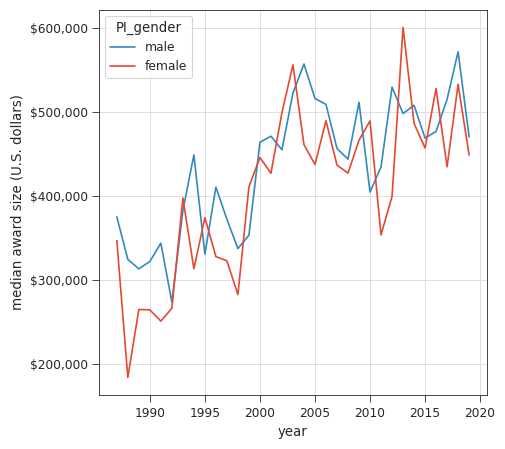

In [9]:
fig, ax = plt.subplots()
_ = sns.lineplot(data=awards, x='year', y='tot_amount_adjusted', hue='PI_gender', estimator=np.median, ci=None, ax=ax)
_ = ax.set(ylabel='median award size (U.S. dollars)')
_ = ax.yaxis.set_major_formatter(fmt)

### Percentage of female co-PIs by PI gender

KDE plot of the percentage of female co-PIs by PI gender and t-test for equal means. Awards with female PIs have a higher percentage of female co-PIs and the difference between the means is statistically significant.

T-test for equal means: t=-7.153, p=0.000, df=1545



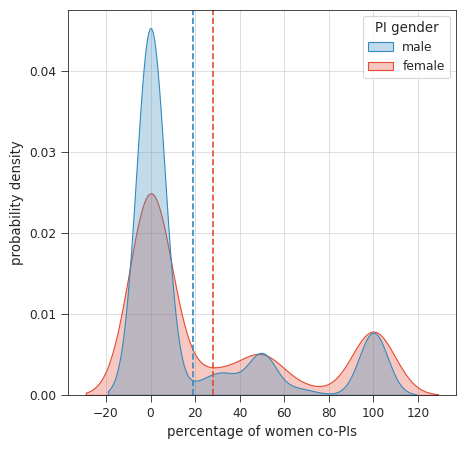

In [10]:
means_female_pct = awards.groupby('PI_gender')['co-PI_female_pct'].mean()
fig, ax = plt.subplots()
_ = sns.kdeplot(data=awards, x='co-PI_female_pct', hue='PI_gender', common_norm=False, alpha=0.3, fill=True, ax=ax)
_ = ax.legend_.set_title('PI gender')
_ = ax.set(xlabel='percentage of women co-PIs', ylabel='probability density')
_ = ax.axvline(means_female_pct['male'], c='C0', ls='--')
_ = ax.axvline(means_female_pct['female'], c='C1', ls='--')

awards_with_copis = awards[awards['num_co-PIs'].notnull()]
awards_with_copis['co-PI_female_pct'] = awards_with_copis['co-PI_female_frac'] * 100

df_male = awards_with_copis[awards_with_copis.PI_gender=='male']
df_female = awards_with_copis[awards_with_copis.PI_gender=='female']
male = df_male['co-PI_female_pct'].dropna().values
female = df_female['co-PI_female_pct'].dropna().values
tstat, pval, df = sm.stats.ttest_ind(male, female, usevar='unequal')
print('T-test for equal means: t={:.3f}, p={:.3f}, df={:.0f}\n'.format(tstat, pval, df))

s1 = awards_with_copis.groupby(['PI_gender'])['co-PI_female_pct'].mean()
s2 = awards_with_copis.groupby(['PI_gender'])['co-PI_female_pct'].count()
df = pd.concat([s1,s2], axis=1, keys=['mean', 'number of awards'])
df.style.format('{0:,.2f}%', subset='mean')

The figure below shows a time series of the annual mean percentage of female co-PIs by PI gender. The shaded area represents the 95% confidence interval of the annual means. For most of the period, the 95% confidence interval overlaps with the lines. So the differences between the annual means from female and male PIs are not statistically significant except for the years 2001, 2003, 2009, 2017 and 2019, as the t-test shows. One possible reason for that is that before 2000, the confidence interval for female PIs is wider due to the realtively low number of awards with female PIs (zero in 1989). As the number of female PI increases, the confidence interval narrows a bit (variance decreases) and we start to see differences that are statistically significant. Nevertheless, the figure indicates that awards with female PIs tend to have a higher percentage of female co-PIs.

Years in which difference between means is statistically significant (p<0.05):

1989 t=4.506, p=0.000, df=95
2001 t=-2.242, p=0.033, df=29
2003 t=-2.088, p=0.045, df=32
2009 t=-3.467, p=0.001, df=87
2017 t=-3.073, p=0.003, df=84
2019 t=-2.310, p=0.024, df=73



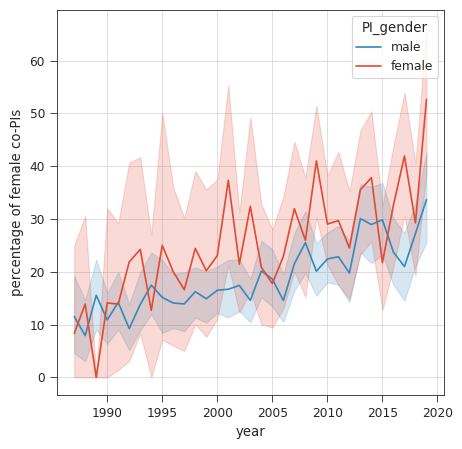

In [11]:
copi_gender_by_pi_gender = awards_with_copis.groupby(['year','PI_gender'])['co-PI_female_pct'].mean().unstack()

# f_error = lambda x: 1.96 * x.std()/np.sqrt(x.size)
# error = awards_with_copis.groupby(['year','PI_gender'])['co-PI_female_pct'].apply(f_error).unstack()
# fig, ax = plt.subplots()
# _ = copi_gender_by_pi_gender[['male','female']].plot(ax=ax)
# x, y_male, y_female = copi_gender_by_pi_gender.index, copi_gender_by_pi_gender.male, copi_gender_by_pi_gender.female
# _ = ax.fill_between(x, y_male - error.male, y_male + error.male, alpha=0.25, color='C0', linewidth=0)
# _ = ax.fill_between(x, y_female - error.female, y_female + error.female, color='C1', alpha=0.25, linewidth=0)
# _ = ax.set(ylabel='% of female co-PIs', title='NSF-OCE awards')

fig, ax = plt.subplots()
_ = sns.lineplot(data=awards, x='year', y='co-PI_female_pct', hue='PI_gender')
_ = ax.set(ylabel='percentage of female co-PIs')

print('Years in which difference between means is statistically significant (p<0.05):\n')
for year in copi_gender_by_pi_gender.index.values:
    male = awards_with_copis[(awards_with_copis.year==year) & (awards_with_copis.PI_gender=='male')]['co-PI_female_pct'].dropna().values
    female = awards_with_copis[(awards_with_copis.year==year) & (awards_with_copis.PI_gender=='female')]['co-PI_female_pct'].dropna().values
    tstat, pval, df = sm.stats.ttest_ind(male, female, usevar='unequal')
    if pval < 0.05:
        print('{} t={:.3f}, p={:.3f}, df={:.0f}'.format(year, tstat, pval, df))

print('')

### Number of co-PIs by PI gender

KDE plot of the number of co-PIs by PI gender and t-test for equal means. Awards with female PIs have a higher number co-PIs. The difference between the means is small but statistically significant.

T-test for equal means: t=-2.545, p=0.011, df=1600



mean  number of awards
PI_gender                            
female     1.812050              1112
male       1.706277              4620

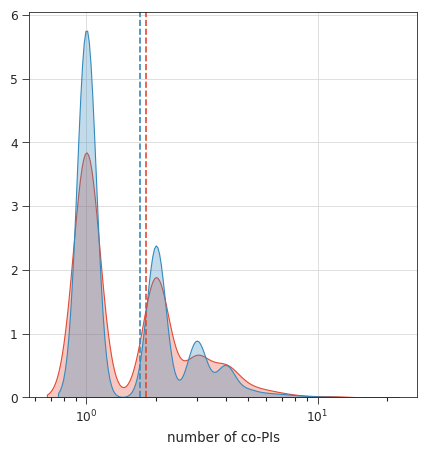

In [12]:
means_num_copi = awards.groupby('PI_gender')['num_co-PIs'].mean()
fig, ax = plt.subplots()
_ = sns.kdeplot(data=awards, x='num_co-PIs', hue='PI_gender', common_norm=False, alpha=0.3, fill=True, legend=False, log_scale=True)
_ = ax.set(xlabel='number of co-PIs', ylabel='')
_ = ax.axvline(means_num_copi['male'], c='C0', ls='--')
_ = ax.axvline(means_num_copi['female'], c='C1', ls='--')

df_male = awards_with_copis[awards_with_copis.PI_gender=='male']
df_female = awards_with_copis[awards_with_copis.PI_gender=='female']
male = df_male['num_co-PIs'].dropna().values
female = df_female['num_co-PIs'].dropna().values
tstat, pval, df = sm.stats.ttest_ind(male, female, usevar='unequal')
print('T-test for equal means: t={:.3f}, p={:.3f}, df={:.0f}\n'.format(tstat, pval, df))

s1 = awards_with_copis.groupby(['PI_gender'])['num_co-PIs'].mean()
s2 = awards_with_copis.groupby(['PI_gender'])['num_co-PIs'].count()
df = pd.concat([s1,s2], axis=1, keys=['mean', 'number of awards'])
df

The figure below shows a time series of the annual mean number of co-PIs by PI gender. The shaded area represents the 95% confidence interval of the annual means.

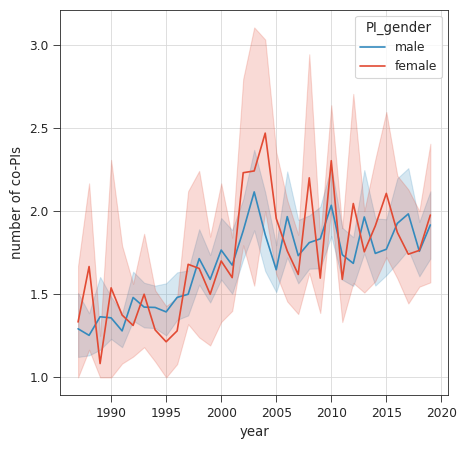

In [13]:
fig, ax = plt.subplots()
_ = sns.lineplot(data=awards, x='year', y='num_co-PIs', hue='PI_gender')
_ = ax.set(ylabel='number of co-PIs')

### Box plot of interdisciplinarity by number of co-PIs 

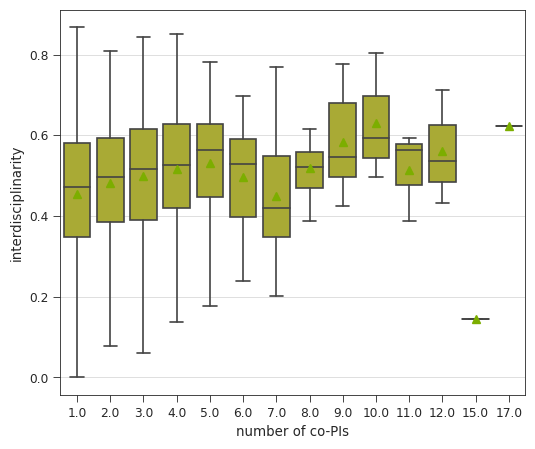

In [14]:
fig, ax = plt.subplots(figsize=(6,5))
_ = sns.boxplot(data=awards, x='num_co-PIs', y='evenness', showfliers=False, showmeans=True, color='C7', ax=ax)
_ = ax.set(ylabel='interdisciplinarity', xlabel='number of co-PIs')

### Line plot of interdisciplinarity by number of co-PIs and PI gender

Interdisciplinarity increases with the number of co-PIs. However, there are very few proposals with more than 5 co-PIs so uncertainty/variability is very high for number of co-PIs > 5.

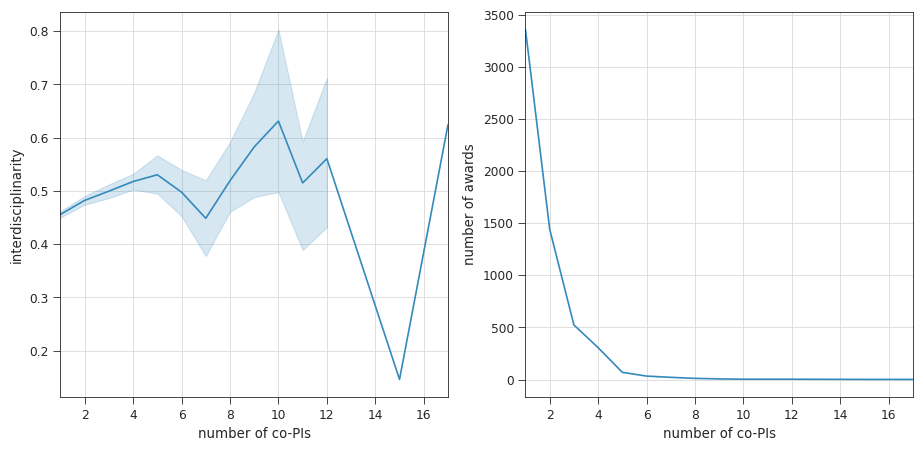

In [15]:
df = awards['num_co-PIs'].value_counts()
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(11,5))
_ = sns.lineplot(data=awards, x='num_co-PIs', y='evenness', ax=axs[0])
_ = axs[0].set(ylabel='interdisciplinarity', xlabel='number of co-PIs')
_ = axs[0].autoscale(axis='x', tight=True)
_ = sns.lineplot(x=df.index, y=df.values, ax=axs[1])
_ = axs[1].set(ylabel='number of awards', xlabel='number of co-PIs')

### Temporal trends in gender composition

The figure below shows the time series of the annual percentage of female PIs and co-PIs across all awards and the percentage of females in the academic workforce between 1987 and 2019. A linear regression fits the data well and female participation in NSF-OCE awards and the workforce seem to be increasing at a rate of approximately 0.65% per year.

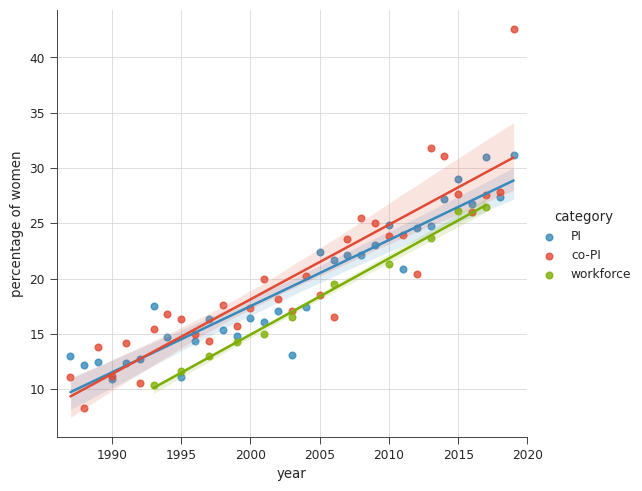

In [16]:
# female & male fraction of PIs
pi_gender = awards.groupby(['year','PI_gender'])['Abstract'].count().unstack()
pi_gender = pi_gender.divide(pi_gender.sum(axis=1), axis=0) * 100 # fraction -> percentage

# female & male fraction of co-PIs
copi_gender = pd.DataFrame({'female':awards.groupby('year')['co-PI_female_frac'].mean()})
copi_gender = copi_gender * 100 # fraction -> percentage

# combine PI, co-PI and workforce data into one dataframe
df_all = pd.concat([pi_gender['female'].rename('PI'), copi_gender.female.rename('co-PI'),
                    workforce.female_pct.rename('workforce')], axis=1).stack()
df_all = df_all.reset_index().rename(columns={'level_1':'category',0:'percentage'})

g = sns.lmplot(data=df_all, x='year', y='percentage', hue='category', aspect=1.1)
_ = g.set(ylabel='percentage of women', xlim=(1986,2020))

In [17]:
def linreg(x, y):
    X = sm.add_constant(x)
    lreg = sm.OLS(y,X).fit()
    return lreg, X

params = []
female_pct = pd.DataFrame({'PI':pi_gender['female'], 'co-PI':copi_gender['female']})
for x, y, in zip([female_pct.index, female_pct.index, workforce.index],
                 [female_pct.PI, female_pct['co-PI'], workforce.female_pct]):
    reg, X = linreg(x, y)
    params.append([reg.rsquared,reg.params[1],reg.params[0],reg.pvalues[1]])
#     p, slope, rsquared = reg.pvalues[1], reg.params[1], reg.rsquared
lr_stats = pd.DataFrame(np.array(params), index=['PI','co-PI','workforce'],
                        columns=['R^2','slope','intercept','p-value'])
lr_stats.style.format('{:.3f}', subset=['R^2','slope','intercept'])

We use a multivariate linear regression of *female percentage* on *time* (year), *category* (PI or co-PI) plus an interaction term (*time* $\times$ *category*) to test whether the temporal trend (slope) and the mean female percentage (intercept) are different between PIs and co-PIs. The table below shows the results from the multivariate linear regression. The large $p$ values for *category* and the interaction term indicate that the differences in intercept and regression slope between PIs and co-PIs are not statistically significant.

In [18]:
import statsmodels.formula.api as smf

df_pi = pd.DataFrame({'fem_pct':female_pct['PI'], 'category':'PI'})
df_copi = pd.DataFrame({'fem_pct':female_pct['co-PI'], 'category':'co-PI'})
df  = pd.concat([df_pi,df_copi]).reset_index()
lreg = smf.ols(formula='fem_pct ~ year + category + year:category', data=df)
res = lreg.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                fem_pct   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     105.1
Date:                Mon, 10 Jul 2023   Prob (F-statistic):           2.86e-24
Time:                        18:15:21   Log-Likelihood:                -159.18
No. Observations:                  66   AIC:                             326.4
Df Residuals:                      62   BIC:                             335.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1178.2040    101.967    -11.555      0.000   -1382.033    -974.375
category[T.co-PI]       -153.4001    144.203     -1.064      0.292    -441.657     134.857
year                       0.5979      0.051     11.744      0.000       0.496       0.700
year:category[T.co-PI]     0.0770      0.072      1.070      0.289      -0.067       0.221
==============================================================================
Omnibus:                       20.244   Durbin-Watson:                   1.575
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.334
Skew:                           0.879   Prob(JB):                     1.94e-11
Kurtosis:                       6.854   Cond. No.                     1.10e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The regression slopes for the award and workforce data are very similar (~0.6). We use a similar multivariate linear regression model of *female percentage* on *time* (year) and *category* (PI, co-PI & workforce) to test if the mean female percentage (intercept) is different between PIs, co-PIs and the workforce. As shown above, the $p$ value (table below) for the co-PI category term indicates that the difference between female representation in PIs and co-PIs is not statistically significant. However, the $p$ value for the workforce category term shows that the lower female percentage in the workforce is statistically significant. This difference is probably because the workforce data represents a wider range of fields, including earth and atmospheric and ocean sciences.

In [19]:
df_work = pd.DataFrame({'fem_pct':workforce.female_pct, 'category':'workforce'})
df  = pd.concat([df_pi,df_copi,df_work]).reset_index()
lreg = smf.ols(formula='fem_pct ~ year + category', data=df)
# lreg = smf.ols(formula='fem_pct ~ year + category + year:category', data=df)
res = lreg.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                fem_pct   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     137.7
Date:                Mon, 10 Jul 2023   Prob (F-statistic):           5.67e-30
Time:                        18:15:21   Log-Likelihood:                -180.76
No. Observations:                  77   AIC:                             369.5
Df Residuals:                      73   BIC:                             378.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1266.1912     63.714    -19.873      0.000   -1393.172   -1139.210
category[T.co-PI]         0.8479      0.640      1.325      0.189      -0.428       2.123
category[T.workforce]    -2.2305      0.906     -2.461      0.016      -4.037      -0.424
year                      0.6418      0.032     20.177      0.000       0.578       0.705
==============================================================================
Omnibus:                       32.343   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.881
Skew:                           1.167   Prob(JB):                     2.07e-27
Kurtosis:                       8.732   Cond. No.                     4.31e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Reference female percentage in academic workforce

As we have seen above, the difference between the regression parameters (slope and intercept) of the percentage of female PIs and co-PIs in NSF awards is not statistically significant. Average percentage of females in the workforce is slightly lower than that in NSF awards (different intercept), but that is most likely a result of the inclusion of earth and atmospheric sciences in the workforce data. Thus, we assume that the temporal trends we see in the percentage of female PIs and co-PIs in NSF awards represent the increasing participation of females in the ocean sciences academic workforce. We then use the linear trend (regression) of the combined data (PIs & co-PIs) as a reference to compare temporal changes in female participation across NSF programs, organizations, research topics and award types with that in the ocean sciences academic workforce.

Combining the PI and co-PI data we get the regression:

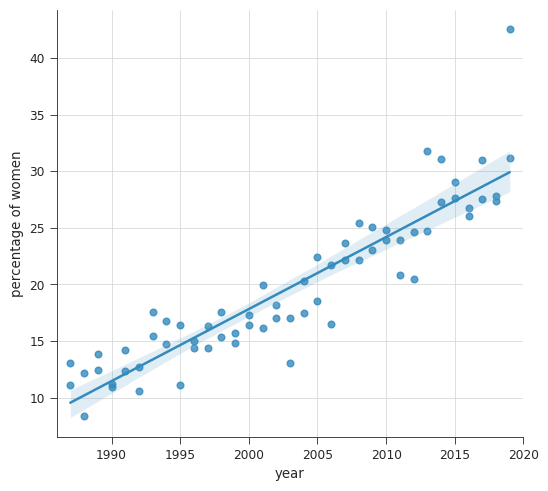

In [20]:
df = pd.concat([df_pi,df_copi]).reset_index()
g = sns.lmplot(data=df, x='year', y='fem_pct', aspect=1.1)
_ = g.set(ylabel='percentage of women', xlim=(1986,2020))

lreg_all, X = linreg(df.year, df.fem_pct)
a, b = lreg_all.params

# Create DataFrame with "reference" female percentage in the ocean sciences academic workforce
years = df.year.unique()
df_ref = pd.DataFrame({'PI':lreg_all.predict(sm.add_constant(years)),
                       'co-PI':lreg_all.predict(sm.add_constant(years))}, index=years)
df_ref.index.name = 'year'
df_ref.columns.name = 'female_pct'
# df_ref.to_csv('results/gender_ref.csv')

## NSF programs

### Top 10 NSF programs in number of awards

The table and histogram below show the top 10 NSF-OCE programs in number of awards for the period 1987-2019.

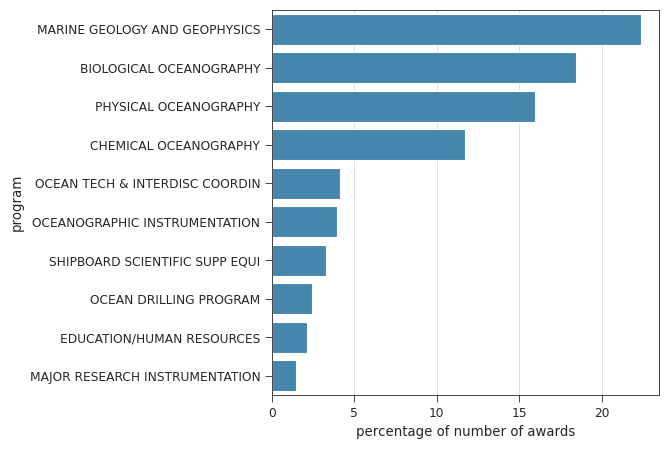

In [21]:
top10_programs = pd.DataFrame({'number of awards':
                      awards.groupby('program')['Abstract'].count().sort_values(ascending=False)[:10]})
top10_programs['percentage of total'] = top10_programs['number of awards'] / len(awards) * 100
top10_programs['cum percentage of total'] = top10_programs['percentage of total'].cumsum() 

fig, ax = plt.subplots()
_ = sns.barplot(data=top10_programs, y=top10_programs.index, x='percentage of total', orient='h', color='C0', ax=ax)
_ = ax.set(xlabel='percentage of number of awards')

top10_programs.style.format('{:.2f}', subset=['percentage of total','cum percentage of total'])

The table and histogram below show the total amount awarded (budget) for the top 10 NSF-OCE programs in number of awards for the period 1987-2019.

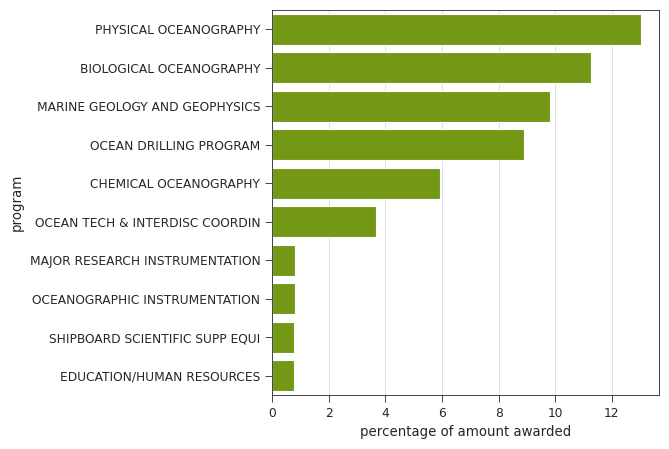

In [22]:
awards_top10 = awards[awards.program.isin(top10_programs.index)]
top10_programs_amount = pd.DataFrame({'amount awarded': awards_top10.groupby('program')['tot_amount_adjusted'].sum().sort_values(ascending=False)})
top10_programs_amount['percentage of total'] = top10_programs_amount['amount awarded'] / awards['tot_amount_adjusted'].sum() * 100
top10_programs_amount['cum percentage of total'] = top10_programs_amount['percentage of total'].cumsum()

fig, ax = plt.subplots()
_ = sns.barplot(data=top10_programs_amount, y=top10_programs_amount.index, x='percentage of total', orient='h', color='C2', ax=ax)
_ = ax.set(xlabel='percentage of amount awarded')

top10_programs_amount.style.format('${0:,.2f}', subset='amount awarded')

Boxplot of award size by program.

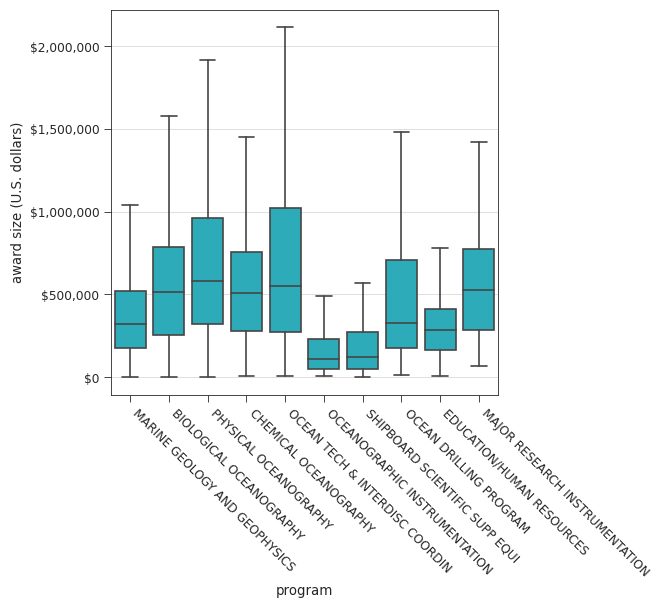

In [23]:
fig, ax = plt.subplots()
_ = sns.boxplot(data=awards_top10, x='program', y='tot_amount_adjusted', showfliers=False,
                order=top10_programs.index, color='C4', ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set_ylabel('award size (U.S. dollars)')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

Boxplot of award size by program and PI gender.

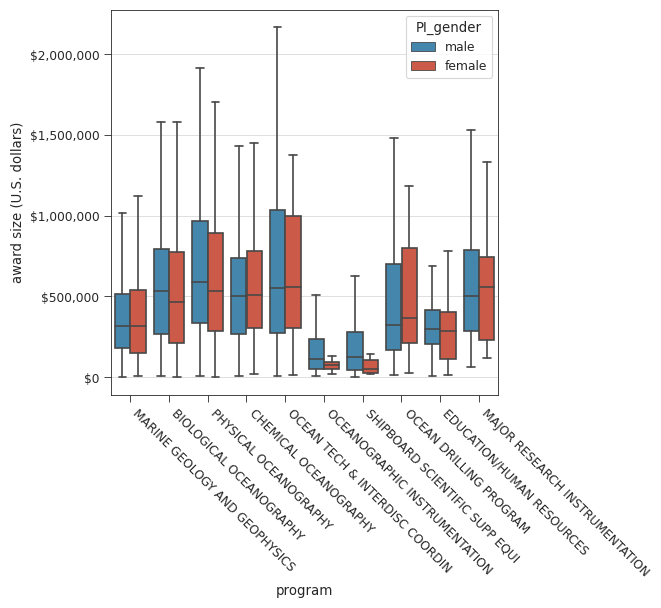

In [24]:
fig, ax = plt.subplots()
_ = sns.boxplot(data=awards_top10, x='program', y='tot_amount_adjusted', showfliers=False,
                order=top10_programs.index, hue='PI_gender', ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set_ylabel('award size (U.S. dollars)')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

The figure below shows the time series of the number of awards and the percentage of awards per year for each of the top 10 programs.

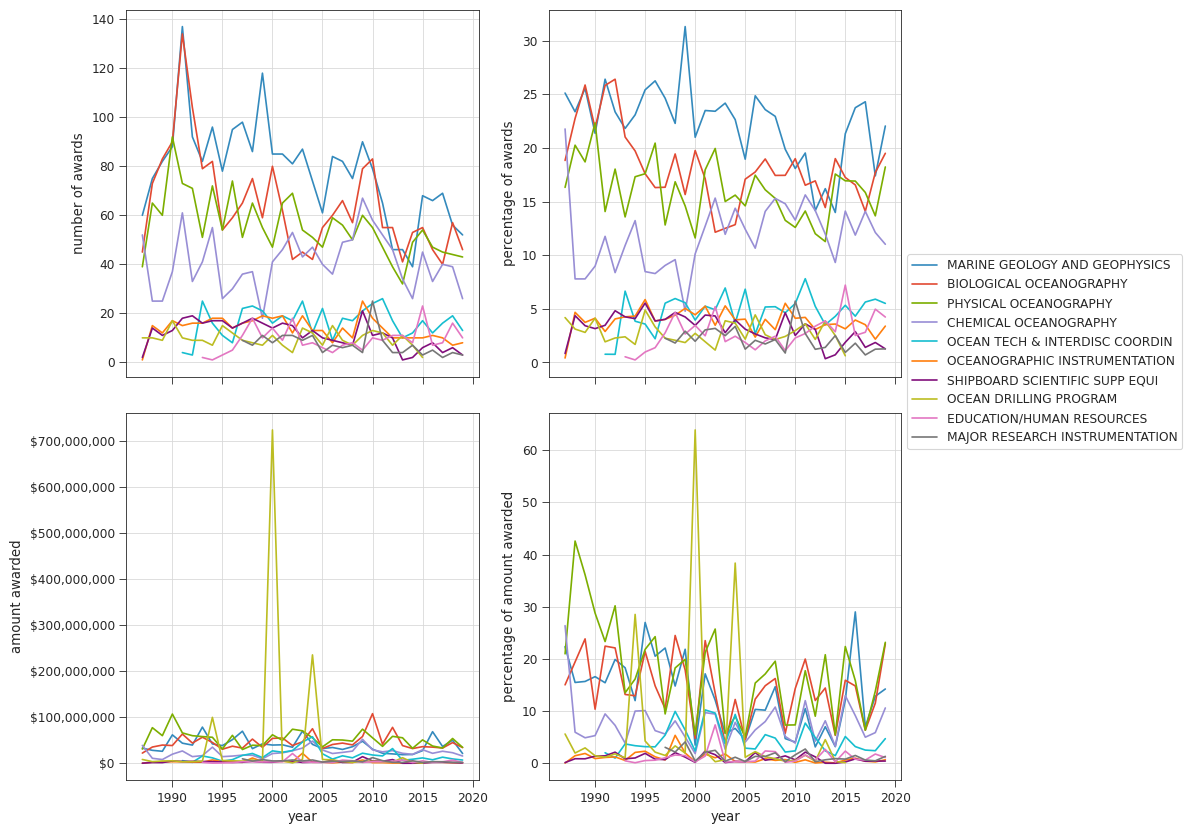

In [25]:
num_awards_per_year = awards.groupby(['year'])['Abstract'].count()
amount_awarded_per_year =  awards.groupby(['year'])['tot_amount_adjusted'].sum()

prog_year = pd.DataFrame({'number of awards': awards_top10.groupby(['year','program'])['Abstract'].count()})
prog_year['percentage of awards'] = prog_year['number of awards'].div(num_awards_per_year, axis=0) * 100
prog_year['amount awarded'] = awards_top10.groupby(['year','program'])['tot_amount_adjusted'].sum()
prog_year['percentage of amount awarded'] = prog_year['amount awarded'].div(amount_awarded_per_year,axis=0) * 100

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10,10))
fig.subplots_adjust(hspace=0.1)
_ = sns.lineplot(data=prog_year, x='year', y='number of awards', hue='program', hue_order=top10_programs.index, ax=axs[0,0], legend=False)
_ = sns.lineplot(data=prog_year, x='year', y='percentage of awards', hue='program', hue_order=top10_programs.index, ax=axs[0,1])
_ = sns.lineplot(data=prog_year, x='year', y='amount awarded', hue='program', hue_order=top10_programs.index, ax=axs[1,0], legend=False)
_ = sns.lineplot(data=prog_year, x='year', y='percentage of amount awarded', hue='program', hue_order=top10_programs.index, ax=axs[1,1], legend=False)
_ = axs[1,0].yaxis.set_major_formatter(fmt)
_ = axs[0,1].legend(loc='upper left',bbox_to_anchor=(1, 0.35))

### Distribution of awards across top 10 NSF-OCE programs by PI gender

The table and figure below show the distribution (relative proportion) of the top 10 NSF-OCE programs within each PI gender in three different 11-year time periods.

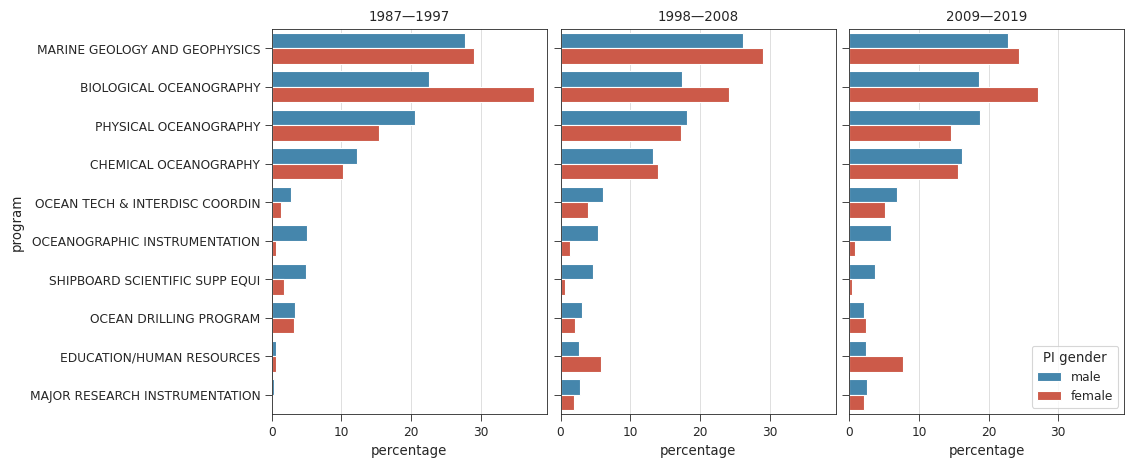

In [26]:
awards_top10_1 = awards_top10[awards_top10.year<1998]                              # 1987-1997
awards_top10_2 = awards_top10[(awards_top10.year>1997) & (awards_top10.year<2009)] # 1998-2008
awards_top10_3 = awards_top10[awards_top10.year>2008]                              # 2009-2019

titles = [u'1987\u20141997',u'1998\u20142008',u'2009\u20142019']
dflist = []

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,5))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [awards_top10_1, awards_top10_2, awards_top10_3], titles):
    df_1 = df.groupby(['program','PI_gender'])['Abstract'].count()
    df_2 = df.groupby(['PI_gender'])['Abstract'].count()
    df_pct = (df_1.div(df_2) * 100).reindex(top10_programs.index, level='program')
    dflist.append(df_pct.unstack())
    df_pct = df_pct.rename('percentage').reset_index()
    _ = sns.barplot(data=df_pct, y='program', x='percentage', orient='h', hue='PI_gender',
                    hue_order=['male','female'], order=top10_programs.index, ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t)

for n in range(1,3):
    _ = axs[n].set_ylabel('')
    
ax.legend(title='PI gender',loc='lower right')

df_top10 = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1)
df_top10.style.format('{:.2f}')

### Gender composition across top 10 programs (in number of awards)

PI gender percentage in the top 10 NSF-OCE programs. The table and figure show the PI gender composition in the top 10 NSF-OCE programs in three different 11-year time periods.

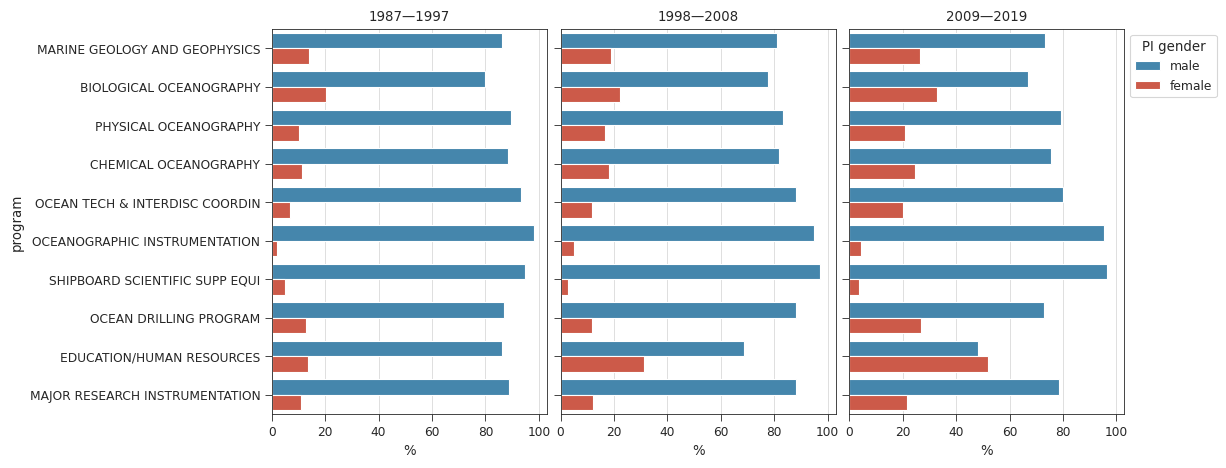

In [27]:
dflist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,5))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [awards_top10_1, awards_top10_2, awards_top10_3], titles):
    df_1 = df.groupby(['program','PI_gender'])['Abstract'].count()
    df_2 = df_1.groupby(['program']).sum()
    df_prog_pi = (df_1.div(df_2) * 100).reindex(top10_programs.index, level='program')
    dflist.append(df_prog_pi.unstack())
    df_prog_pi = df_prog_pi.rename('percentage').reset_index()
    _ = sns.barplot(data=df_prog_pi, y='program', x='percentage', hue='PI_gender',
                    hue_order=['male','female'], order=top10_programs.index, ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t, xlabel='%')

for n in range(1,3):
    _ = axs[n].set_ylabel('')

ax.legend(title='PI gender',loc='upper left',bbox_to_anchor=(1, 1))

by_program_pi = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1)
by_program_pi.style.format('{:.2f}')

co-PI gender percentage in the top 10 NSF-OCE programs. The table and figure show the co-PI gender composition in the top 10 NSF-OCE programs in three different 11-year time periods.

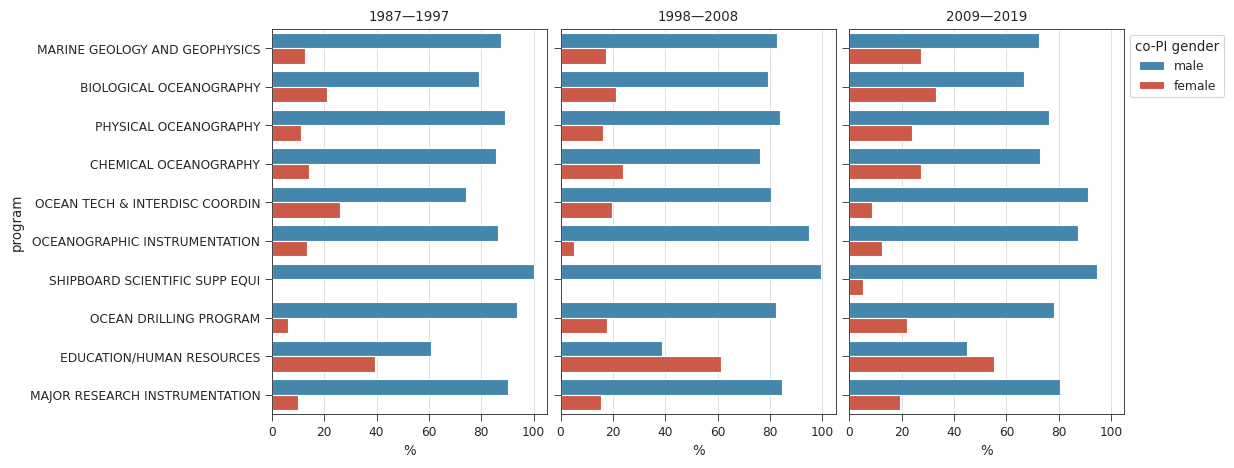

In [28]:
dflist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,5))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [awards_top10_1, awards_top10_2, awards_top10_3], titles):
    df_prog_copi = pd.DataFrame({'female': df.groupby(['program'])['co-PI_female_frac'].mean()})
    df_prog_copi['male'] = 1 - df_prog_copi.female
    df_prog_copi.columns.name = 'co-PI gender'
    df_prog_copi = df_prog_copi.reindex(top10_programs.index) * 100 # fraction -> percentage
    dflist.append(df_prog_copi)
    df = df_prog_copi.stack().rename('percentage').reset_index()
    _ = sns.barplot(data=df, y='program', x='percentage', hue='co-PI gender',
                    hue_order=['male','female'], order=top10_programs.index, ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t, xlabel='%')

for n in range(1,3):
    _ = axs[n].set_ylabel('')

ax.legend(title='co-PI gender',loc='upper left',bbox_to_anchor=(1, 1))

by_program_copi = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1)
by_program_copi.style.format('{:.2f}')

### Changes in gender composition across top 10 programs (in number of awards)

The figure below shows the annual percentage of female PIs and co-PIs for each of the top 10 NSF-OCE programs (in number of awards). Solid lines represent the linear regression fit, the shaded area represent the 95% confidence interval and points represent the individual years. The table shows the linear regressions results.

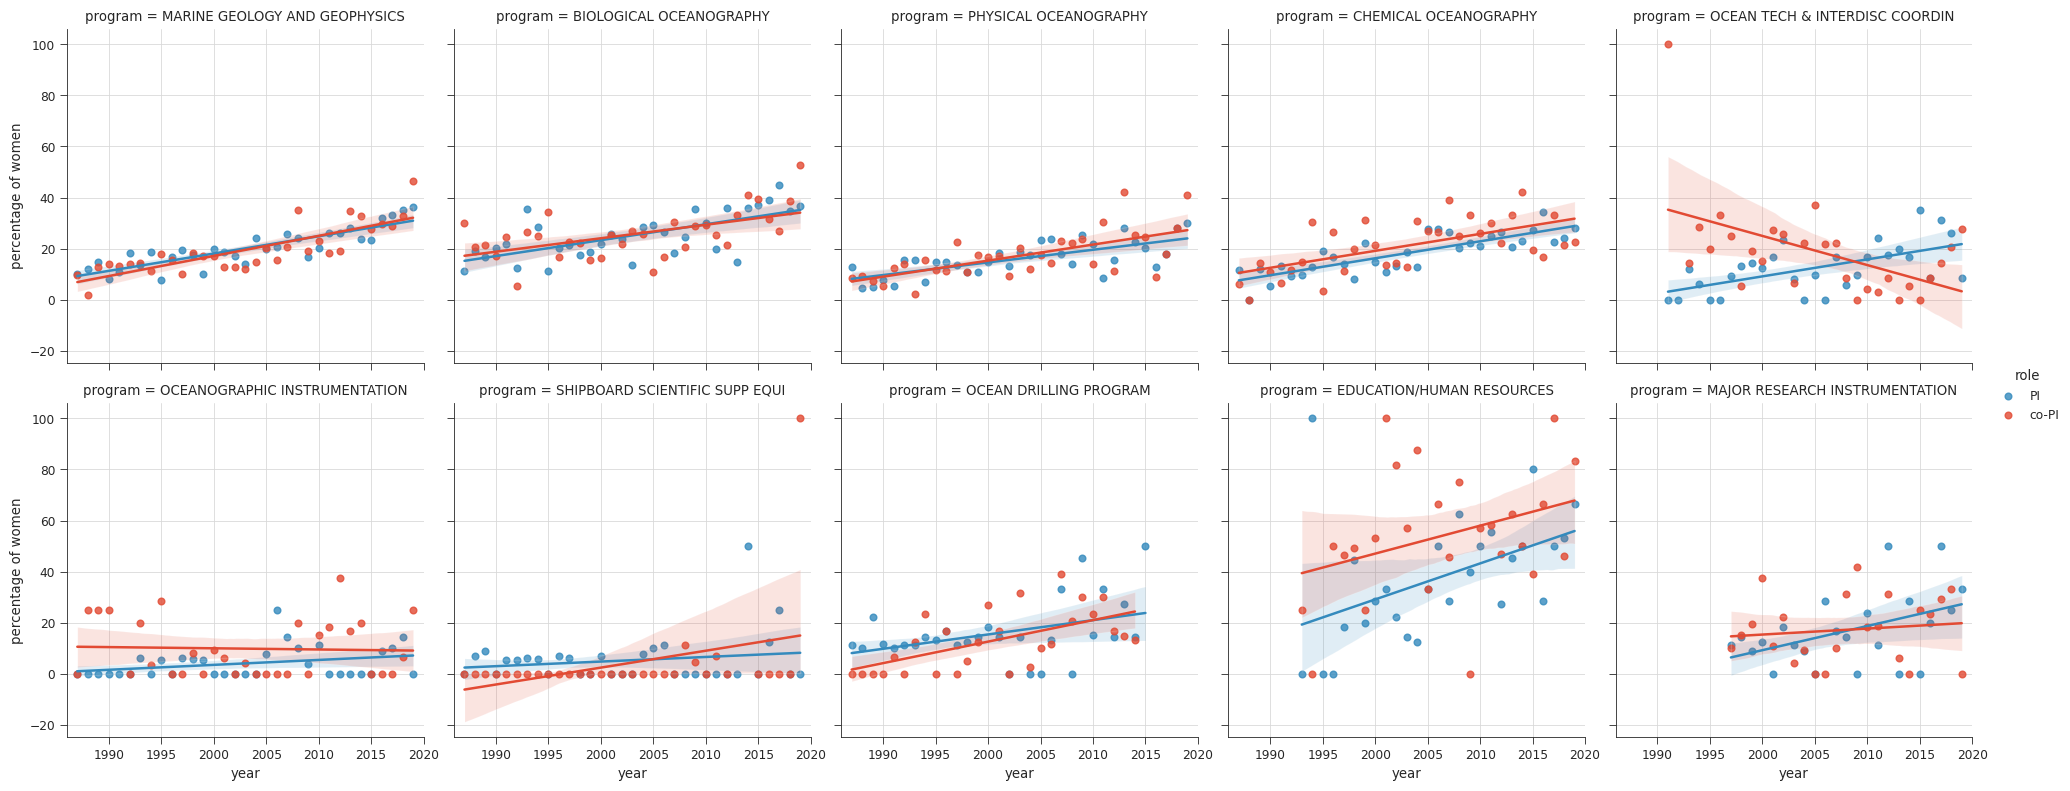

In [29]:
# female fraction of PIs
df = awards_top10.groupby(['program','year','PI_gender'])['Abstract'].count().unstack()
pi_female_pct_by_program = df.fillna(0).divide(df.sum(axis=1), axis=0)['female'] * 100
# female fraction of co-PIs
copi_female_pct_by_program = awards_top10.groupby(['program','year'])['co-PI_female_frac'].mean() * 100
# combined data
female_pct_by_program = pd.DataFrame({'PI':pi_female_pct_by_program, 'co-PI':copi_female_pct_by_program})
female_pct_by_program = female_pct_by_program.stack().reset_index().rename(columns={'level_2':'role',0:'percentage'})
# plot linear regression
g = sns.lmplot(x='year', y='percentage', data=female_pct_by_program, hue='role',
               col='program', col_wrap=5, col_order=top10_programs.index, height=4)
_ = g.set(xlim=(1986,2020))
for n in [0, 5]:
    _ = g.axes[n].set(ylabel='percentage of women')

female_pct = female_pct_by_program.set_index(['program','year','role']).unstack()
female_pct.columns = female_pct.columns.get_level_values(1)
params = []
for prog in top10_programs.index:
    lreg_pi, X = linreg(female_pct.loc[prog].index, female_pct.loc[prog,'PI'])
    lreg_copi, X = linreg(female_pct.loc[prog].dropna().index, female_pct.loc[prog,'co-PI'].dropna())
    params.append([lreg_pi.rsquared, lreg_pi.params[1], lreg_pi.pvalues[1],
                   lreg_copi.rsquared, lreg_copi.params[1], lreg_copi.pvalues[1]])

lr_stats = pd.DataFrame(np.array(params), index=top10_programs.index,
                        columns=[['PI','PI','PI','co-PI','co-PI','co-PI'],
                                 ['R^2','slope','p-value','R^2','slope','p-value']])
lr_stats.style.format('{:.3f}', subset=['PI','co-PI'])

The results from the regression below show that the difference in mean female percentage (intercept) between PIs and co-PIs in CHEMICAL OCEANOGRAPHY is not statistically significant.

In [30]:
prog = 'CHEMICAL OCEANOGRAPHY'
df1 = pd.DataFrame({'fem_pct':female_pct.loc[prog,'PI'], 'category':'PI'})
df2 = pd.DataFrame({'fem_pct':female_pct.loc[prog,'co-PI'], 'category':'co-PI'})
df  = pd.concat([df1,df2]).reset_index()
df.rename(columns={'StartDate': 'year'},inplace=True)
lreg = smf.ols(formula='fem_pct ~ year + category', data=df)
# lreg = smf.ols(formula='fem_pct ~ year + category + year:category', data=df)
res = lreg.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                fem_pct   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     31.14
Date:                Mon, 10 Jul 2023   Prob (F-statistic):           3.94e-10
Time:                        18:15:37   Log-Likelihood:                -217.42
No. Observations:                  66   AIC:                             440.8
Df Residuals:                      63   BIC:                             447.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1311.4816    172.879     -7.586      0.000   -1656.952    -966.011
category[T.co-PI]     2.9035      1.644      1.767      0.082      -0.381       6.188
year                  0.6639      0.086      7.692      0.000       0.491       0.836
==============================================================================
Omnibus:                        1.000   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.607   Jarque-Bera (JB):                1.028
Skew:                           0.276   Prob(JB):                        0.598
Kurtosis:                       2.739   Cond. No.                     4.21e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.21e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
# fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9,8))
# for ax, prog in zip(axs.ravel(),
#                     ['MARINE GEOLOGY AND GEOPHYSICS','BIOLOGICAL OCEANOGRAPHY', 'PHYSICAL OCEANOGRAPHY', 'CHEMICAL OCEANOGRAPHY']):
#     df = female_pct.loc[prog]
#     _ = sns.regplot(df.index, df.PI, ax=ax)
#     _ = sns.regplot(df.index, df['co-PI'], ax=ax)
#     _ = ax.set_title(prog)

### Differences in gender composition with respect to academic workforce

Using the linear trend for the combined data (PI and co_PI) as reference we compute anomalies that represent how female percentage/representation differs from that in the ocean sciences academic workforce. The figure below shows a stem plot of the anomalies for the top 10 NSF-OCE programs. The table shows the sum of the anomalies for each program which is a metric of how each program is performing relative to the academic workforce. Positive and negative values indicate that the program is overperforming and underperforming female representation in the academic workforce, respectively.

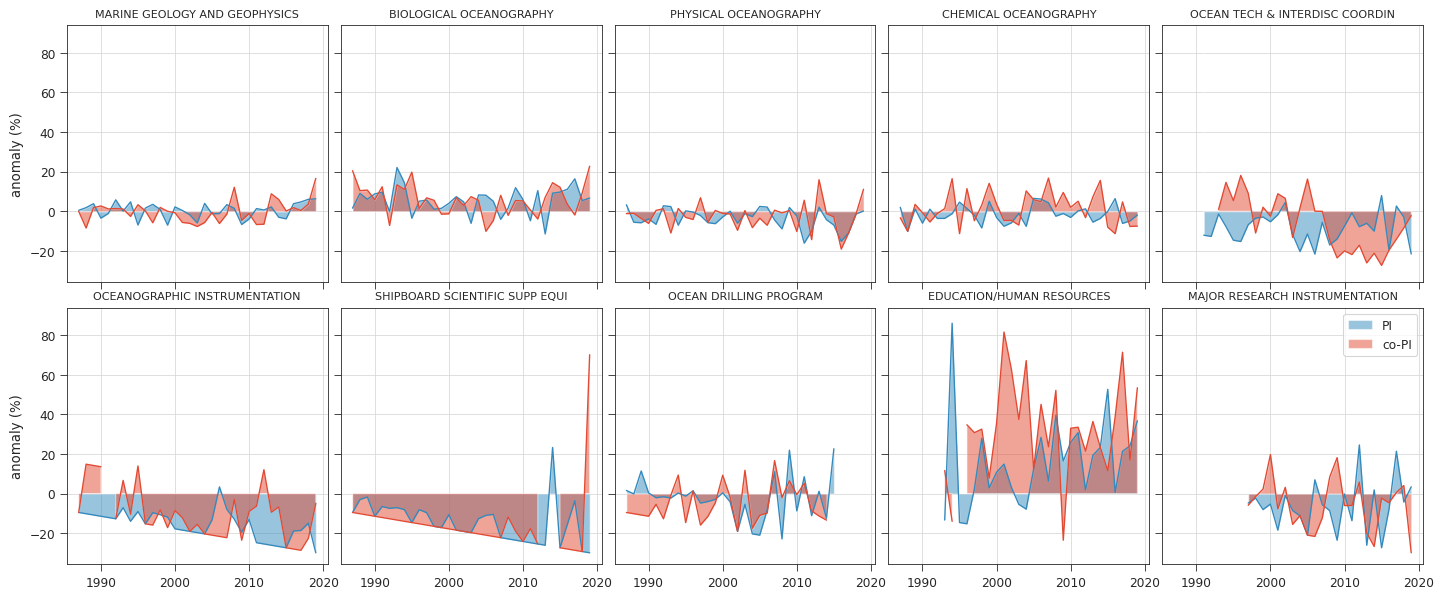

In [32]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(17.5, 7))
fig.subplots_adjust(hspace=0.1, wspace=0.05)
params = []
for ax, prog in zip(axs.ravel(), top10_programs.index):
    anom = female_pct.loc[prog] - df_ref
    _ = ax.fill_between(anom.index.values, anom.PI, alpha=0.5, label='PI')
    _ = ax.fill_between(anom.index.values, anom['co-PI'], alpha=0.5, label='co-PI')
    _ = ax.plot(anom.index.values, anom.PI, linewidth=1)
    _ = ax.plot(anom.index.values, anom['co-PI'], linewidth=1)   
    _ = ax.set_title(prog, fontsize=8)
    params.append([anom.sum()[0], anom.sum()[1]])

for i in range(2):
    _ = axs[i,0].set_ylabel('anomaly (%)')

_ = ax.legend(loc='best')

df_anom = pd.DataFrame(data=params, index=top10_programs.index, columns=['PI', 'co-PI'])
df_anom.columns.name = 'total sum'
df_anom.style.format('{:.2f}')

## Academic organizations

### Top 10 academic organizations in number of awards

In [33]:
# shorten some organization names
awards.loc[awards.Organization == 'University of Miami Rosenstiel School of Marine&Atmospheric Sci',
           'Organization'] = 'University of Miami RSMAS'
awards.loc[awards.Organization == 'University of California-San Diego Scripps Inst of Oceanography',
           'Organization'] = 'UCSD Scripps Institution of Oceanography'

The table and histogram below show the top 10 academic organizations in number of awards for the period 1987-2019.

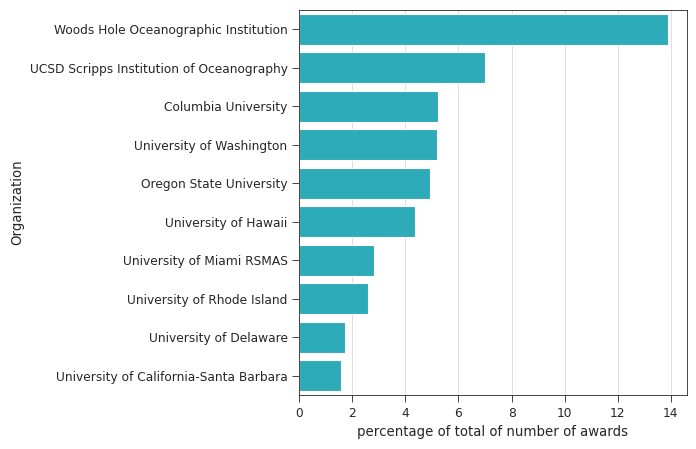

In [34]:
top10_orgs = pd.DataFrame({'number of awards': awards.Organization.value_counts()[:10]})
top10_orgs['percentage of total'] = top10_orgs['number of awards']/len(awards)*100
top10_orgs['cum percentage of total'] = top10_orgs['percentage of total'].cumsum()

fig, ax = plt.subplots()
_ = sns.barplot(data=top10_orgs, y=top10_orgs.index, x='percentage of total', orient='h', color='C4', ax=ax)
_ = ax.set(xlabel='percentage of total of number of awards')

top10_orgs.style.format('{:.2f}', subset=['percentage of total','cum percentage of total'])

The table and histogram below show the total amount awarded for the top 10 academic organizations in number of awards for the period 1987-2019.

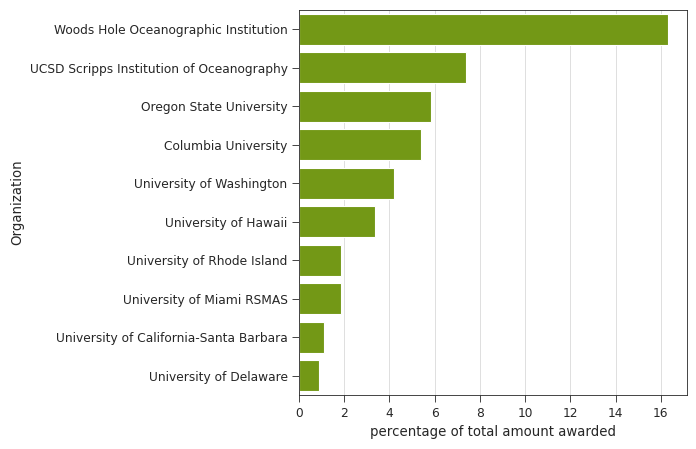

In [35]:
top10_orgs_amount = pd.DataFrame(
    {'amount awarded': awards.groupby('Organization')['tot_amount_adjusted'].sum()[top10_orgs.index]})
top10_orgs_amount['percentage of total'] = (top10_orgs_amount['amount awarded']/
                                     awards.tot_amount_adjusted.sum()*100)
top10_orgs_amount['cum percentage of total'] = top10_orgs_amount['percentage of total'].cumsum()
top10_orgs_amount = top10_orgs_amount.sort_values('amount awarded', ascending=False)

fig, ax = plt.subplots()
_ = sns.barplot(data=top10_orgs_amount, y=top10_orgs_amount.index, x='percentage of total', orient='h', color='C2', ax=ax)
_ = ax.set(xlabel='percentage of total amount awarded')

top10_orgs_amount.style.format('${0:,.2f}', subset='amount awarded')

Boxplot of award size by academic organization.

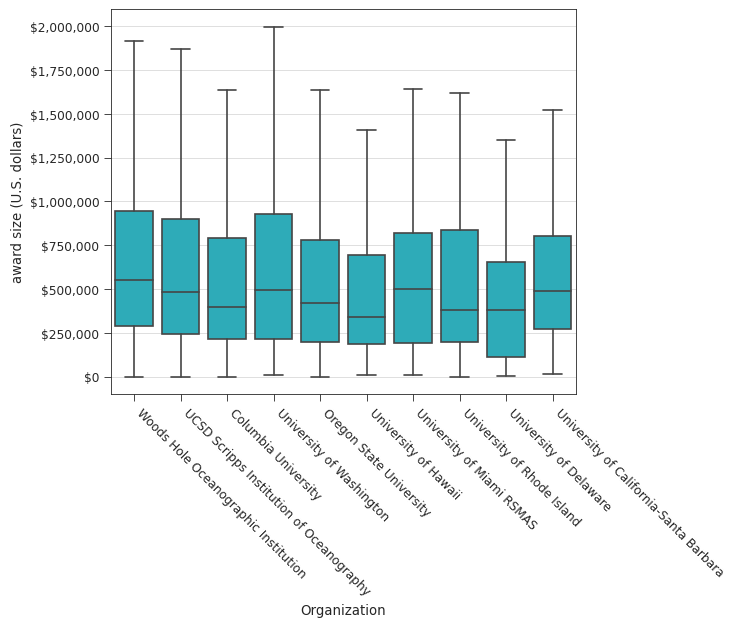

In [36]:
awards_top10_orgs = awards[awards.Organization.isin(top10_orgs.index)]
fig, ax = plt.subplots(figsize=(6,5))
_ = sns.boxplot(x='Organization', y='tot_amount_adjusted', data=awards_top10_orgs,
                showfliers=False, color='C4', order=top10_orgs.index, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(ylabel='award size (U.S. dollars)')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

The figure below shows the time series of the number of awards and the percentage of awards per year for each of the top 10 organizations.

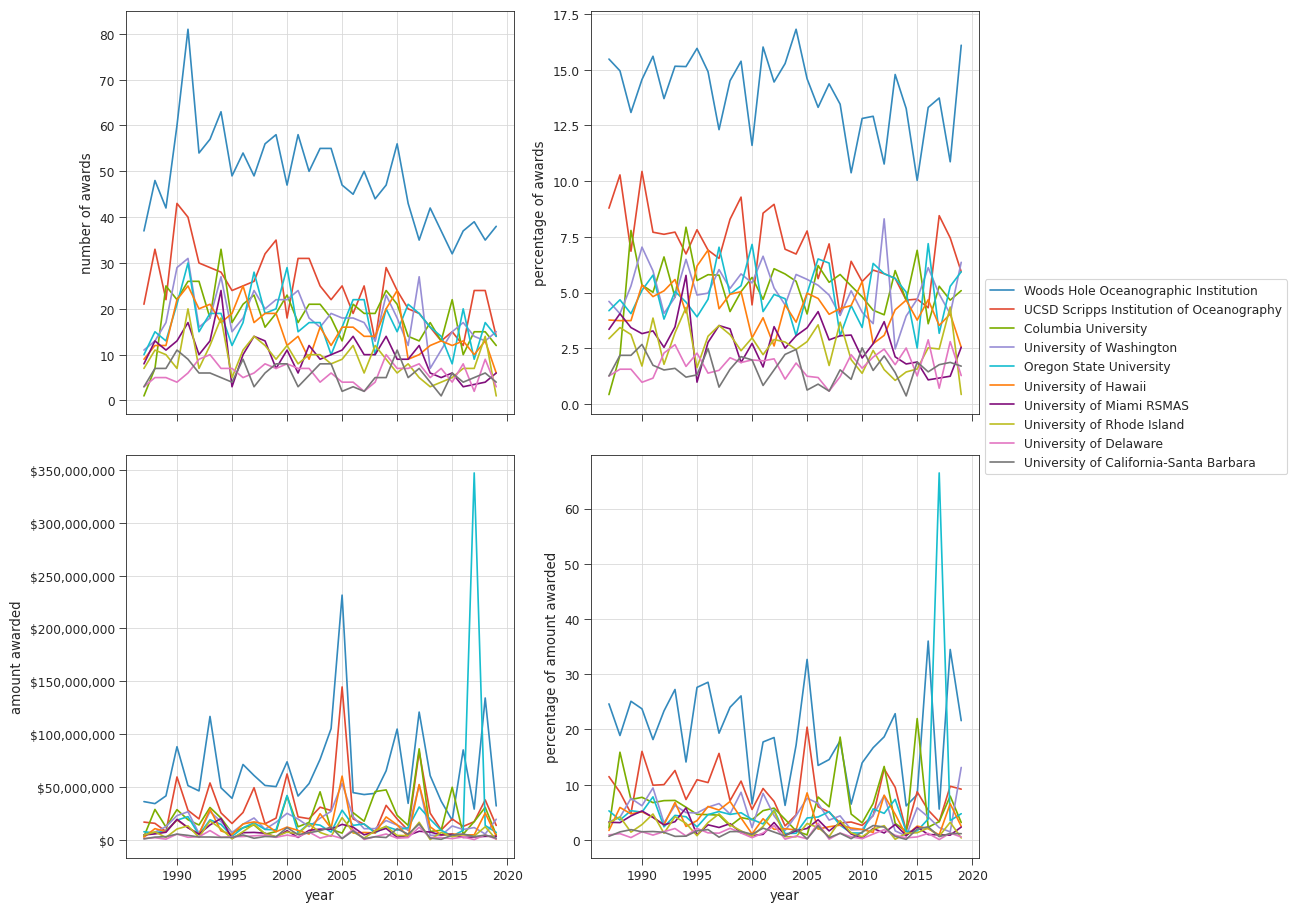

In [37]:
org_year = pd.DataFrame({'number of awards':awards_top10_orgs.groupby(['year','Organization'])['Abstract'].count()})
org_year['percentage of awards'] = org_year['number of awards'].div(num_awards_per_year, axis=0) * 100
org_year['amount awarded'] = awards_top10_orgs.groupby(['year','Organization'])['tot_amount_adjusted'].sum()
org_year['percentage of amount awarded'] = org_year['amount awarded'].div(amount_awarded_per_year,axis=0) * 100

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(11,11))
fig.subplots_adjust(hspace=0.1)
_ = sns.lineplot(x='year', y='number of awards', data=org_year, hue='Organization', ax=axs[0,0], hue_order=top10_orgs.index, legend=False)
_ = sns.lineplot(x='year', y='percentage of awards', data=org_year, hue='Organization', ax=axs[0,1], hue_order=top10_orgs.index)
_ = sns.lineplot(x='year', y='amount awarded', data=org_year, hue='Organization', ax=axs[1,0], hue_order=top10_orgs.index, legend=False)
_ = sns.lineplot(x='year', y='percentage of amount awarded', data=org_year, hue='Organization', ax=axs[1,1], hue_order=top10_orgs.index, legend=False)
_ = axs[0,1].legend(loc='upper left',bbox_to_anchor=(1, 0.35))
_ = axs[1,0].yaxis.set_major_formatter(fmt)

### Gender composition across top 10 organizations

PI gender percentage in the top 10 organizations. The table and figure show the PI gender composition in the top 10 organizations in three different 11-year time periods.

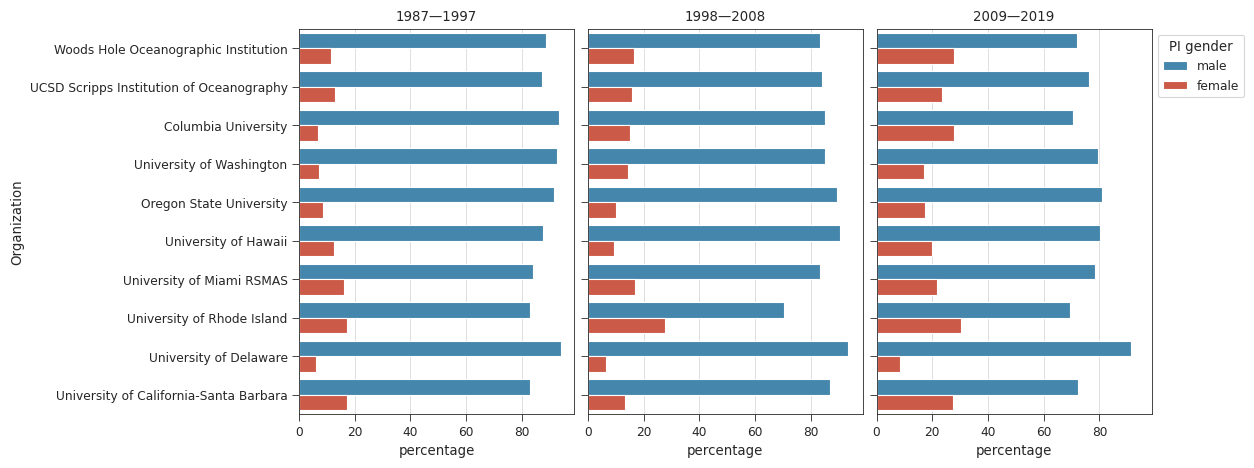

In [38]:
df_org_1 = awards_top10_orgs[awards_top10_orgs.year<1998]                                   # 1987-1997
df_org_2 = awards_top10_orgs[(awards_top10_orgs.year>1997) & (awards_top10_orgs.year<2009)] # 1998-2008
df_org_3 = awards_top10_orgs[awards_top10_orgs.year>2008]                                   # 2009-2019

dflist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,5))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [df_org_1, df_org_2, df_org_3], titles):
    df_1 = df.groupby(['Organization','PI_gender'])['Abstract'].count()
    df_2 = df.groupby(['Organization'])['Abstract'].count()
    df_pct = (df_1.fillna(0).div(df_2) * 100).reindex(top10_orgs.index, level='Organization')
    dflist.append(df_pct.unstack())
    df_pct = df_pct.rename('percentage').reset_index()
    _ = sns.barplot(data=df_pct, y='Organization', x='percentage', orient='h', hue='PI_gender',
                    hue_order=['male','female'], order=top10_orgs.index, ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t)

for n in range(1,3):
    _ = axs[n].set_ylabel('')
    
ax.legend(title='PI gender',loc='upper left', bbox_to_anchor=(1, 1))

df_top10 = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1)
df_top10.style.format('{:.2f}')

co-PI gender percentage in the top 10 organizations. The table and figure show the co-PI gender composition in the top 10 organizations in three different 11-year time periods.

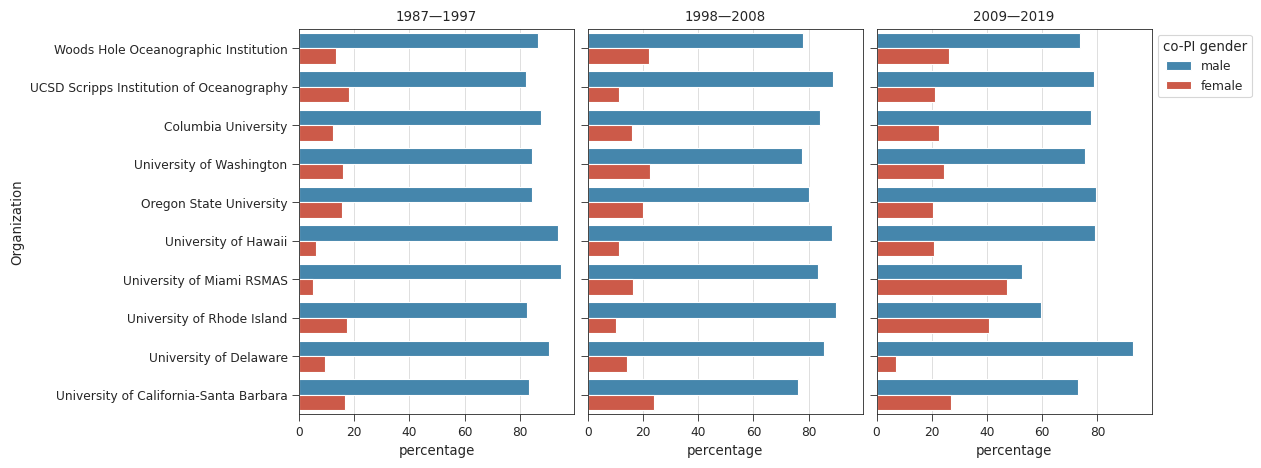

In [39]:
dflist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,5))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [df_org_1, df_org_2, df_org_3], titles):
    df_org_copi = pd.DataFrame({'female': df.groupby(['Organization'])['co-PI_female_frac'].mean()})
    df_org_copi['male'] = 1 - df_org_copi.female
    df_org_copi.columns.name = 'co-PI gender'
    df_org_copi = df_org_copi.reindex(top10_orgs.index) * 100 # fraction -> percentage
    dflist.append(df_org_copi)
    df = df_org_copi.stack().reset_index().rename(columns={'level_0':'Organization', 0:'percentage'})
    _ = sns.barplot(data=df, y='Organization', x='percentage', hue='co-PI gender',
                    hue_order=['male','female'], order=top10_orgs.index, ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t, xlabel='percentage')

for n in range(1,3):
    _ = axs[n].set_ylabel('')

ax.legend(title='co-PI gender',loc='upper left',bbox_to_anchor=(1, 1))

by_org_copi = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1)
by_org_copi.style.format('{:.2f}')

### Changes in gender composition across top 10 organizations

The figure below shows time series of the annual percentage of female PIs and co-PIs for each of the top 10 academic organizations (in number of awards). Solid lines represent the linear regression fit, the shaded area represents the 95% confidence interval and points represent the individual years. The table shows the linear regressions results.

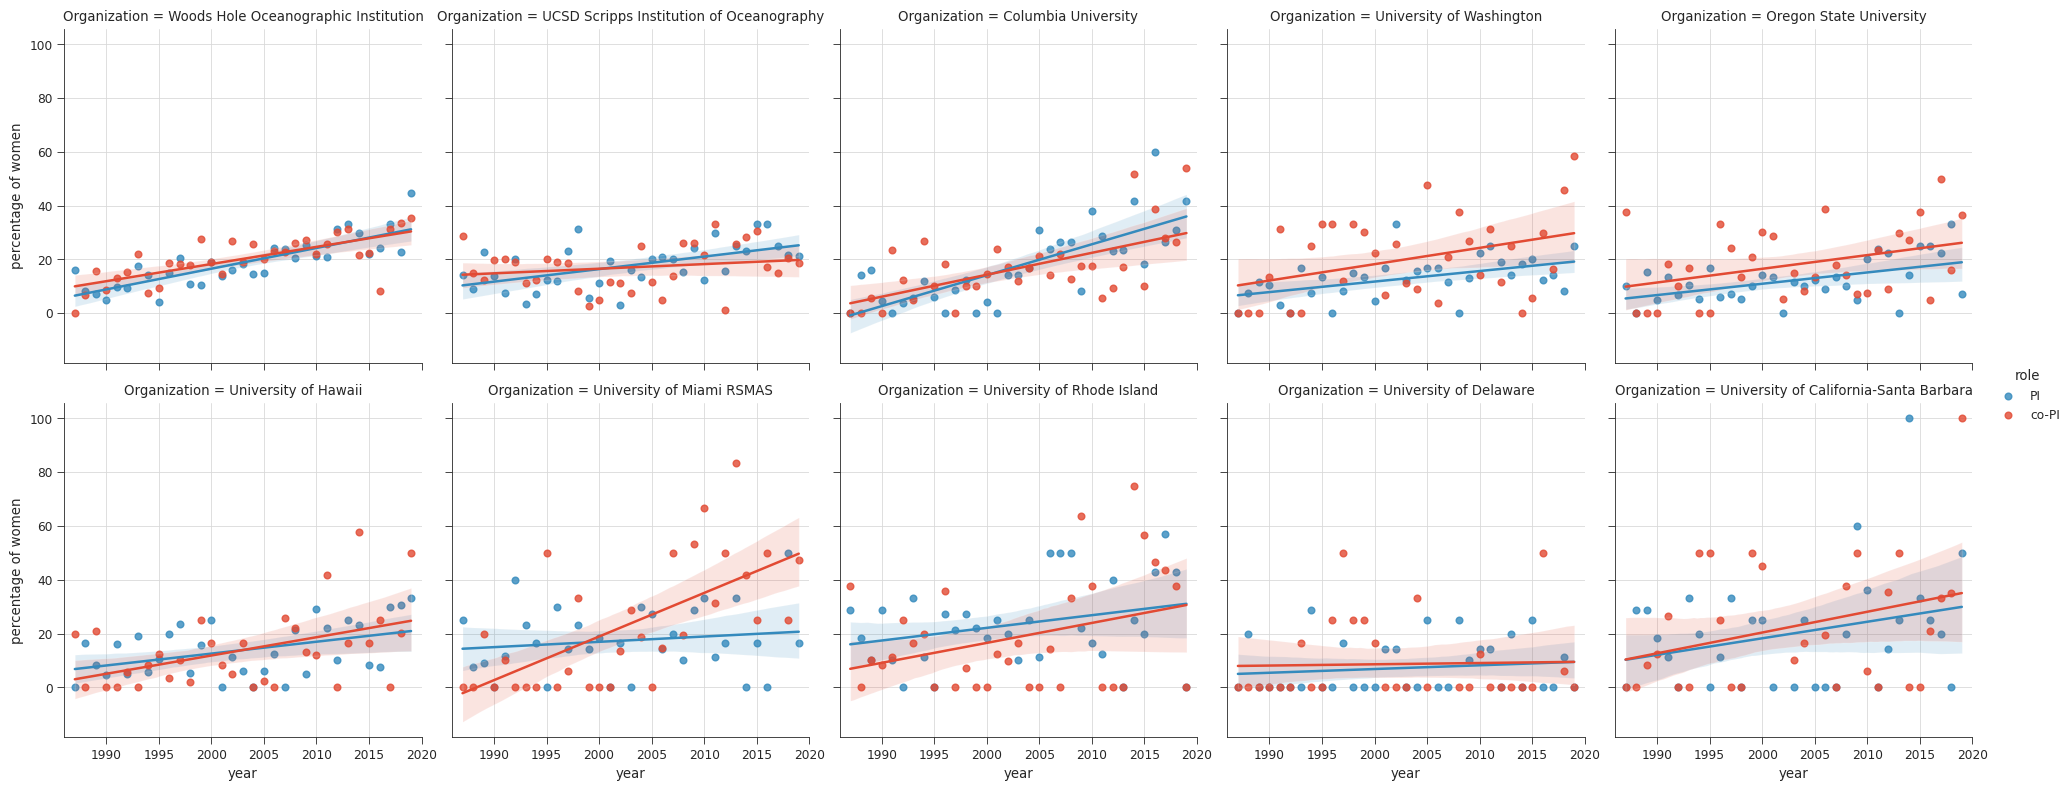

In [40]:
# female fraction of PIs
df = awards_top10_orgs.groupby(['Organization','year','PI_gender'])['Abstract'].count().unstack()
pi_gender_by_org = df.fillna(0).divide(df.sum(axis=1), axis=0)['female']
# female fraction of co-PIs
copi_gender_by_org = awards_top10_orgs.groupby(['Organization','year'])['co-PI_female_frac'].mean()
# combine PI & co-PI data
female_pct_by_org = pd.DataFrame({'PI':pi_gender_by_org * 100, 'co-PI': copi_gender_by_org * 100})
female_pct_by_org = female_pct_by_org.stack().reset_index().rename(columns={'level_2':'role',0:'percentage'})
# plot linear regression
g = sns.lmplot(x='year', y='percentage', data=female_pct_by_org, hue='role',
               col='Organization', col_wrap=5, col_order=top10_orgs.index, height=4)
_ = g.set(xlim=(1986,2020))
for n in [0, 5]:
    _ = g.axes[n].set(ylabel='percentage of women')

female_pct = female_pct_by_org.set_index(['Organization','year','role']).unstack()
female_pct.columns = female_pct.columns.get_level_values(1)
params = []
for org in top10_orgs.index:
    lreg_pi, X = linreg(female_pct.loc[org].index, female_pct.loc[org,'PI'])
    lreg_copi, X = linreg(female_pct.loc[org].dropna().index, female_pct.loc[org,'co-PI'].dropna())
    params.append([lreg_pi.rsquared, lreg_pi.params[1], lreg_pi.pvalues[1],
                   lreg_copi.rsquared, lreg_copi.params[1], lreg_copi.pvalues[1]])

lr_stats = pd.DataFrame(np.array(params), index=top10_programs.index,
                        columns=[['PI','PI','PI','co-PI','co-PI','co-PI'],
                                 ['R^2','slope','p-value','R^2','slope','p-value']])
lr_stats.style.format('{:.3f}', subset=['PI','co-PI'])

### Differences in gender composition with respect to academic workforce

Using the linear trend for the combined data (PI and co_PI) as reference we compute anomalies that represent how female percentage/representation differs from that in the ocean sciences academic workforce. The figure below shows a stem plot of the anomalies for the top 10 academic organizations. The table shows the sum of the anomalies for each organization which is a metric of how each organization is performing relative to the academic workforce. Positive and negative values indicate that the organization is overperforming and underperforming female representation in the academic workforce, respectively.

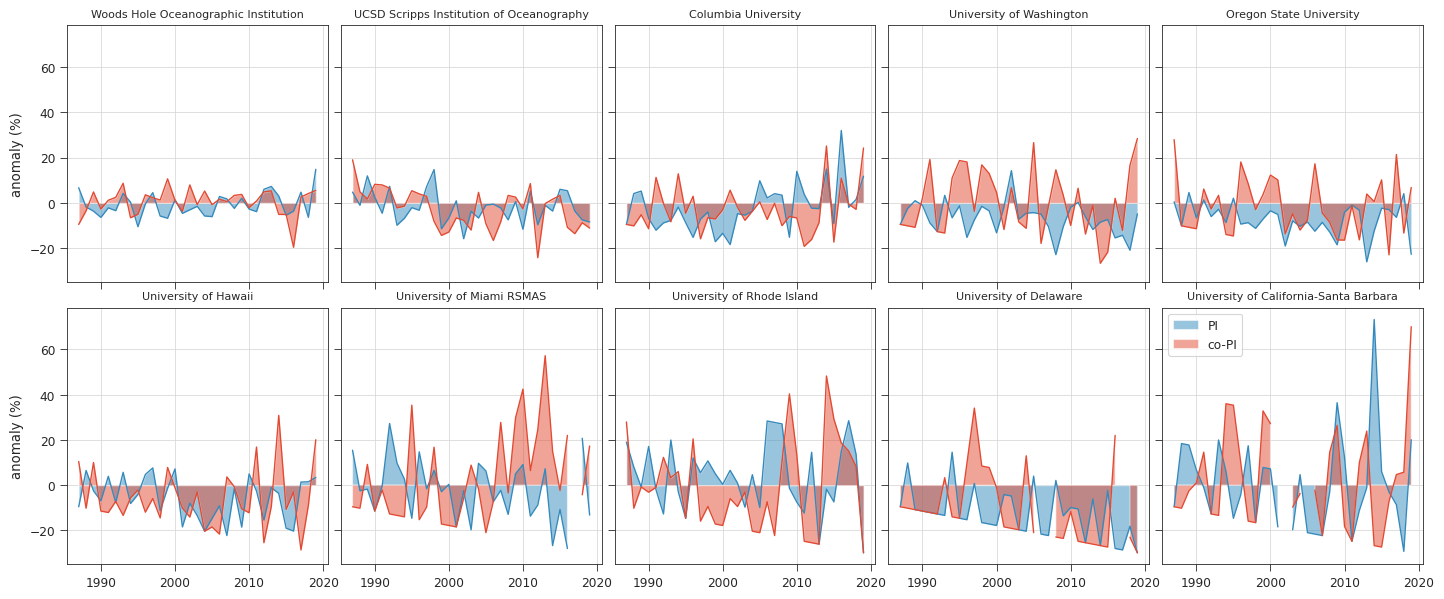

In [41]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(17.5, 7))
fig.subplots_adjust(hspace=0.1, wspace=0.05)
params = []
for ax, org in zip(axs.ravel(), top10_orgs.index):
    anom = female_pct.loc[org] - df_ref
    _ = ax.fill_between(anom.index.values, anom.PI, alpha=0.5, label='PI')
    _ = ax.fill_between(anom.index.values, anom['co-PI'], alpha=0.5, label='co-PI')
    _ = ax.plot(anom.index.values, anom.PI, linewidth=1)
    _ = ax.plot(anom.index.values, anom['co-PI'], linewidth=1)       
    _ = ax.set_title(org, fontsize=8)
    params.append([anom.sum()[0], anom.sum()[1]])

for i in range(2):
    _ = axs[i,0].set_ylabel('anomaly (%)')

_ = ax.legend(loc='best')

df_anom = pd.DataFrame(data=params, index=top10_orgs.index, columns=['PI', 'co-PI'])
df_anom.columns.name = 'total sum'
df_anom.style.format('{:.2f}')

## Research topics

Similarly to what was done in [Lima & Rheuban, 2018](https://tos.org/oceanography/article/topics-and-trends-in-nsf-ocean-sciences-awards), we applied non-negative matrix factorization (NMF) to the NSF-OCE abstracts to extract 22 research topics.

The table and histogram below show the number of awards and relative frequency of awards per research topic for the period 1987-2019.

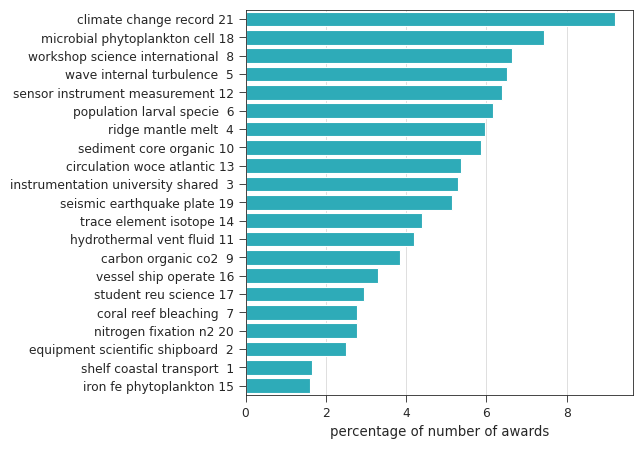

In [42]:
res_topics = pd.DataFrame({'number of awards':awards.groupby('topic')['Abstract'].count().sort_values(ascending=False)})
res_topics.index = topic_names[res_topics.index.values - 1]
res_topics['percentage of total'] = res_topics['number of awards'] / len(awards) * 100
res_topics['cum percentage of total'] = res_topics['percentage of total'].cumsum() 

fig, ax = plt.subplots()
_ = sns.barplot(data=res_topics, y=res_topics.index, x='percentage of total', orient='h', color='C4', ax=ax)
_ = ax.set(xlabel='percentage of number of awards')

res_topics.style.format('{:.2f}', subset=['percentage of total','cum percentage of total'])

The table and histogram below show the total amount awarded per research topic for the period 1987-2019.

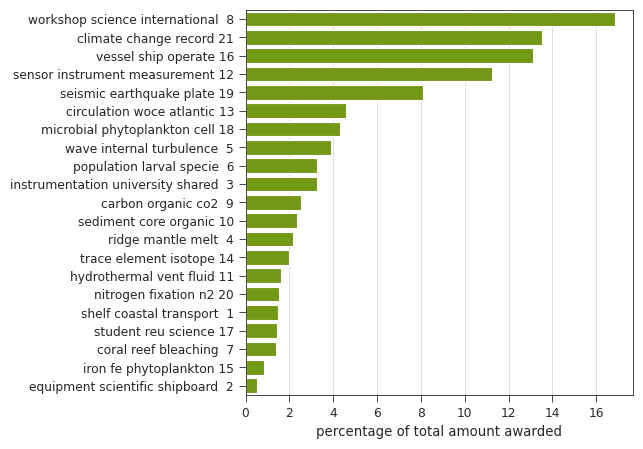

In [43]:
res_topics_amount = pd.DataFrame({'amount awarded':awards.groupby('topic')['tot_amount_adjusted'].sum().sort_values(ascending=False)})
res_topics_amount.index = topic_names[res_topics_amount.index.values - 1]
res_topics_amount['percentage of total'] = res_topics_amount['amount awarded'] / awards.tot_amount_adjusted.sum() * 100
res_topics_amount['cum percentage of total'] = res_topics_amount['percentage of total'].cumsum() 

fig, ax = plt.subplots()
_ = sns.barplot(data=res_topics_amount, y=res_topics_amount.index, x='percentage of total', orient='h', color='C2', ax=ax)
_ = ax.set(xlabel='percentage of total amount awarded')

res_topics_amount.style.format('${0:,.2f}', subset='amount awarded')

Boxplot of award size by research topic. Topics are grouped by program

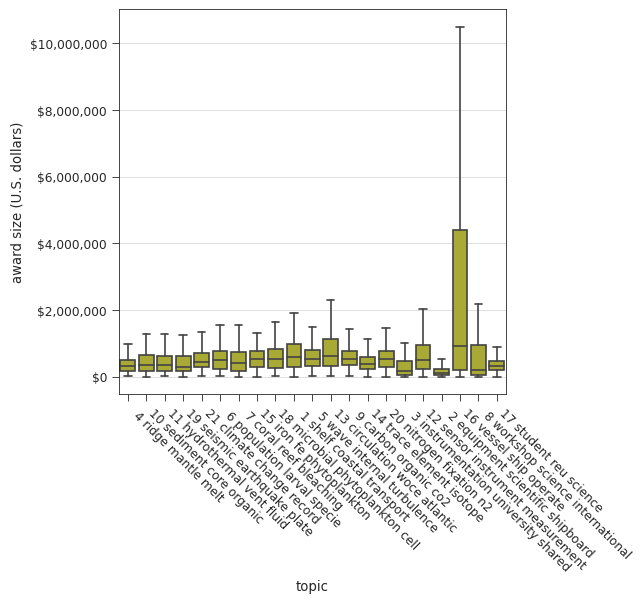

In [44]:
topic_order = np.array([4,10,11,19,21,6,7,15,18,1,5,13,9,14,20,3,12,2,16,8,17]) # order topics by program
fig, ax = plt.subplots()
_ = sns.boxplot(x='topic', y='tot_amount_adjusted', data=awards, showfliers=False,
                order=topic_order, color='C7', ax=ax )
_ = ax.set(xticklabels=topic_names_r[topic_order-1])
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set_ylabel('award size (U.S. dollars)')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

Boxplot of award size by research topic and PI gender. Topics are grouped by program

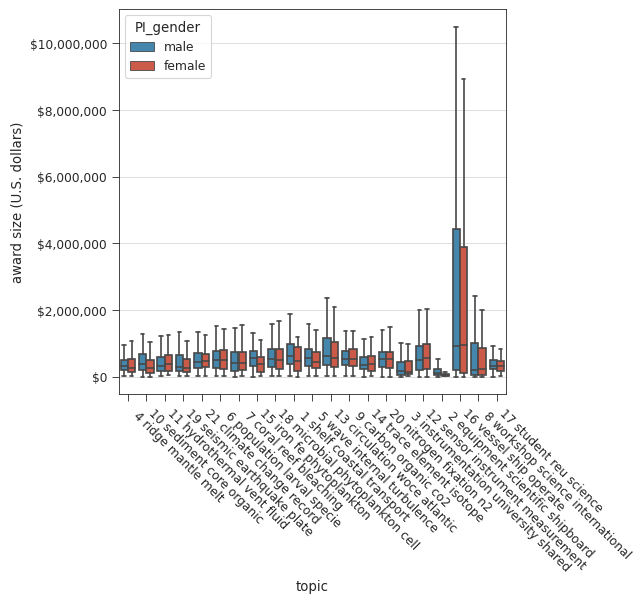

In [45]:
fig, ax = plt.subplots()
_ = sns.boxplot(data=awards, x='topic', y='tot_amount_adjusted', showfliers=False,
                orient='v', hue='PI_gender', order=topic_order, ax=ax)
_ = ax.set(xticklabels=topic_names_r[topic_order-1])
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set_ylabel('award size (U.S. dollars)')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

### Frequency distribution of topics by PI gender

The table and figure below show the distribution (relative proportion) of different topics by PI gender. They show how the awards from each gender (PI) are distributed across the different topics.

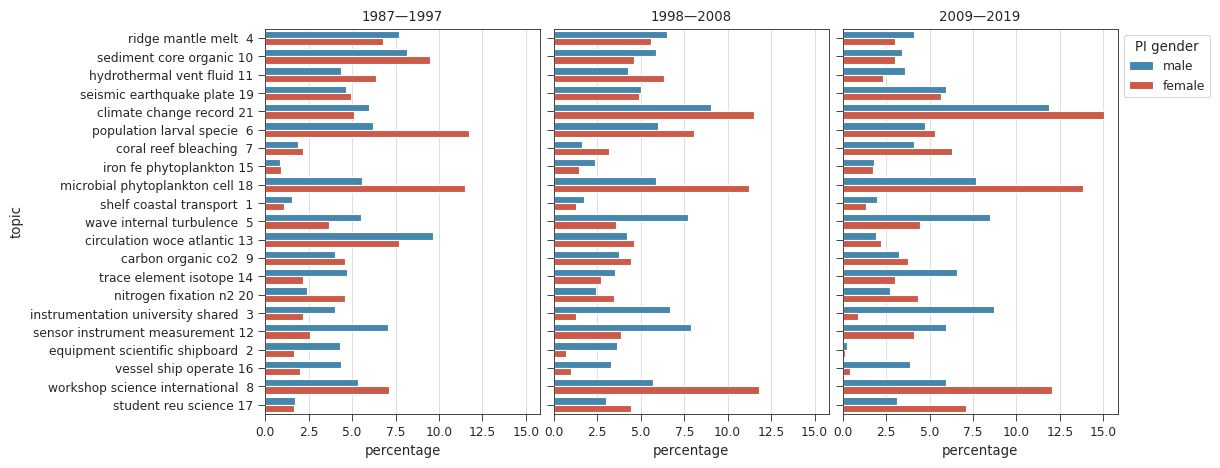

In [46]:
awards_1 = awards[awards.year<1998]                        # 1987-1997
awards_2 = awards[(awards.year>1997) & (awards.year<2009)] # 1998-2008
awards_3 = awards[awards.year>2008]                        # 2009-2019

dflist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,5))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [awards_1, awards_2, awards_3], titles):
    df_1 = df.groupby(['topic','PI_gender'])['Abstract'].count()
    df_2 = df.groupby(['PI_gender'])['Abstract'].count()
    df_pct = (df_1.div(df_2) * 100)
    df_pct = df_pct.unstack()
    df_pct = df_pct.reindex(topic_order)
    df_pct.index = topic_names[topic_order-1]
    dflist.append(df_pct)
    df_pct = df_pct.stack().reset_index().rename(columns={'level_0':'topic', 0:'percentage'})
    _ = sns.barplot(data=df_pct, y='topic', x='percentage', orient='h', hue='PI_gender',
                    hue_order=['male','female'], ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t)

for n in range(1,3):
    _ = axs[n].set_ylabel('')
    
ax.legend(title='PI gender',loc='upper left',bbox_to_anchor=(1, 1))

df_topics = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1)
df_topics.style.format('{:.2f}')

### Gender composition across research topics

PI gender percentage across research topics. Gender composition of PIs in the different research topics.

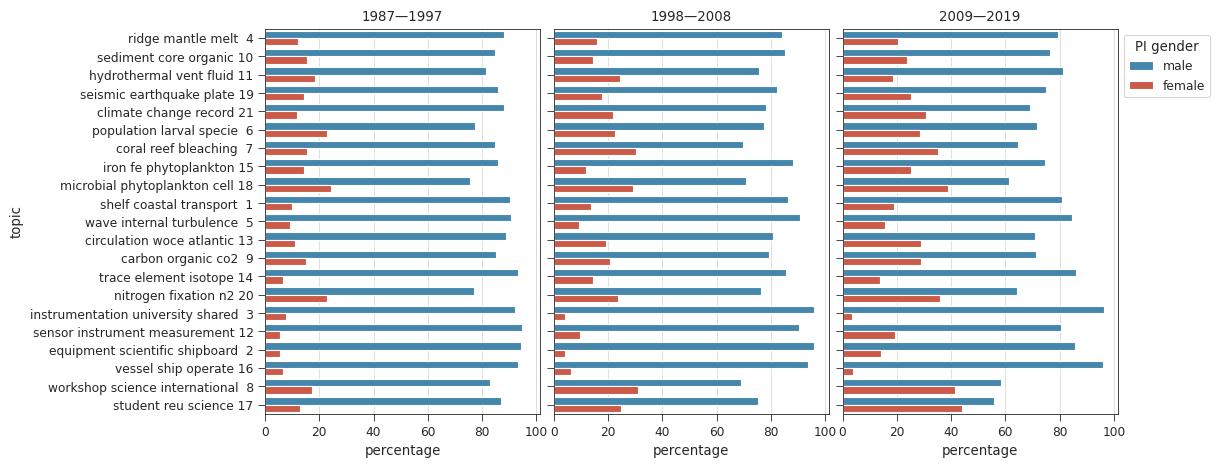

In [47]:
dflist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,5))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [awards_1, awards_2, awards_3], titles):
    df_pct = df.groupby(['topic','PI_gender'])['Abstract'].count().unstack()
    df_pct = df_pct.fillna(0).divide(df_pct.sum(axis=1), axis=0) * 100 # fraction -> percentage
    df_pct = df_pct.reindex(topic_order)
    df_pct.index = topic_names[topic_order-1]
    dflist.append(df_pct)
    df_pct = df_pct.stack().reset_index().rename(columns={'level_0':'topic', 0:'percentage'})
    _ = sns.barplot(data=df_pct, y='topic', x='percentage', orient='h', hue='PI_gender',
                    hue_order=['male','female'], ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t)

for n in range(1,3):
    _ = axs[n].set_ylabel('')

ax.legend(title='PI gender',loc='upper left',bbox_to_anchor=(1, 1))

by_topic_pi = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1)
by_topic_pi.style.format('{:.2f}')

co-PI gender percentage across research topics. Gender composition of co-PIs in the different research topics.

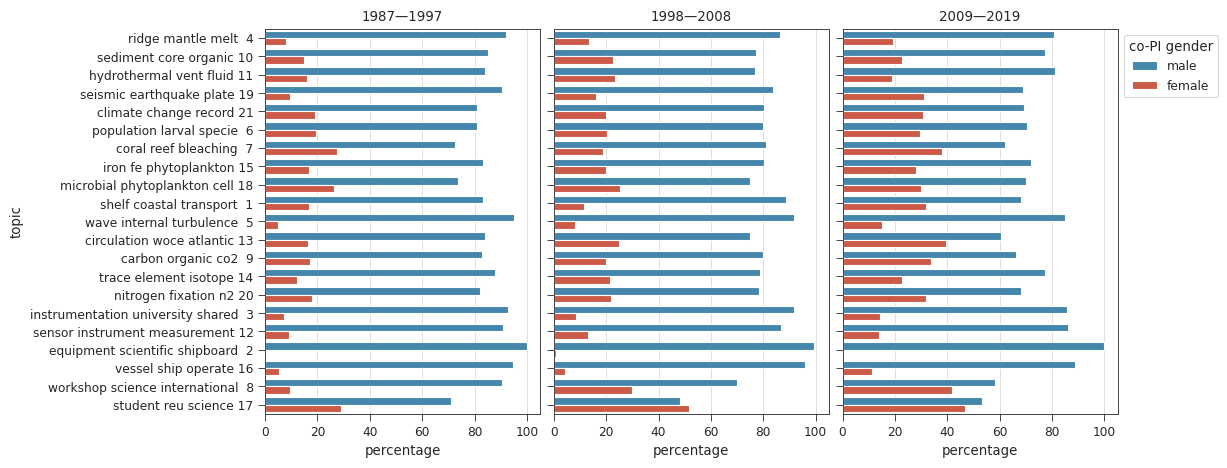

In [48]:
dflist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,5))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [awards_1, awards_2, awards_3], titles):
    df_pct = pd.DataFrame({'female':df.groupby(['topic'])['co-PI_female_frac'].mean()})
    df_pct['male'] = 1 - df_pct.female
    df_pct = df_pct.reindex(topic_order) * 100 # fraction -> percentage
    df_pct.index = topic_names[topic_order-1]
    df_pct.columns.name = 'co-PI gender'
    dflist.append(df_pct)
    df_pct = df_pct.stack().reset_index().rename(columns={'level_0':'topic', 0:'percentage'})
    _ = sns.barplot(data=df_pct, y='topic', x='percentage', orient='h', hue='co-PI gender',
                    hue_order=['male','female'], ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t)
    
for n in range(1,3):
    _ = axs[n].set_ylabel('')

ax.legend(title='co-PI gender',loc='upper left',bbox_to_anchor=(1, 1))

by_topic_copi = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1)
by_topic_copi.style.format('{:.2f}')

### Changes in gender composition across research topics

The figure below shows time series of the annual percentage of female PIs and co-PIs for each of the identified research topics. Solid lines represent the linear regression fit, the shaded area represents the 95% confidence interval and the points represent the individual years.

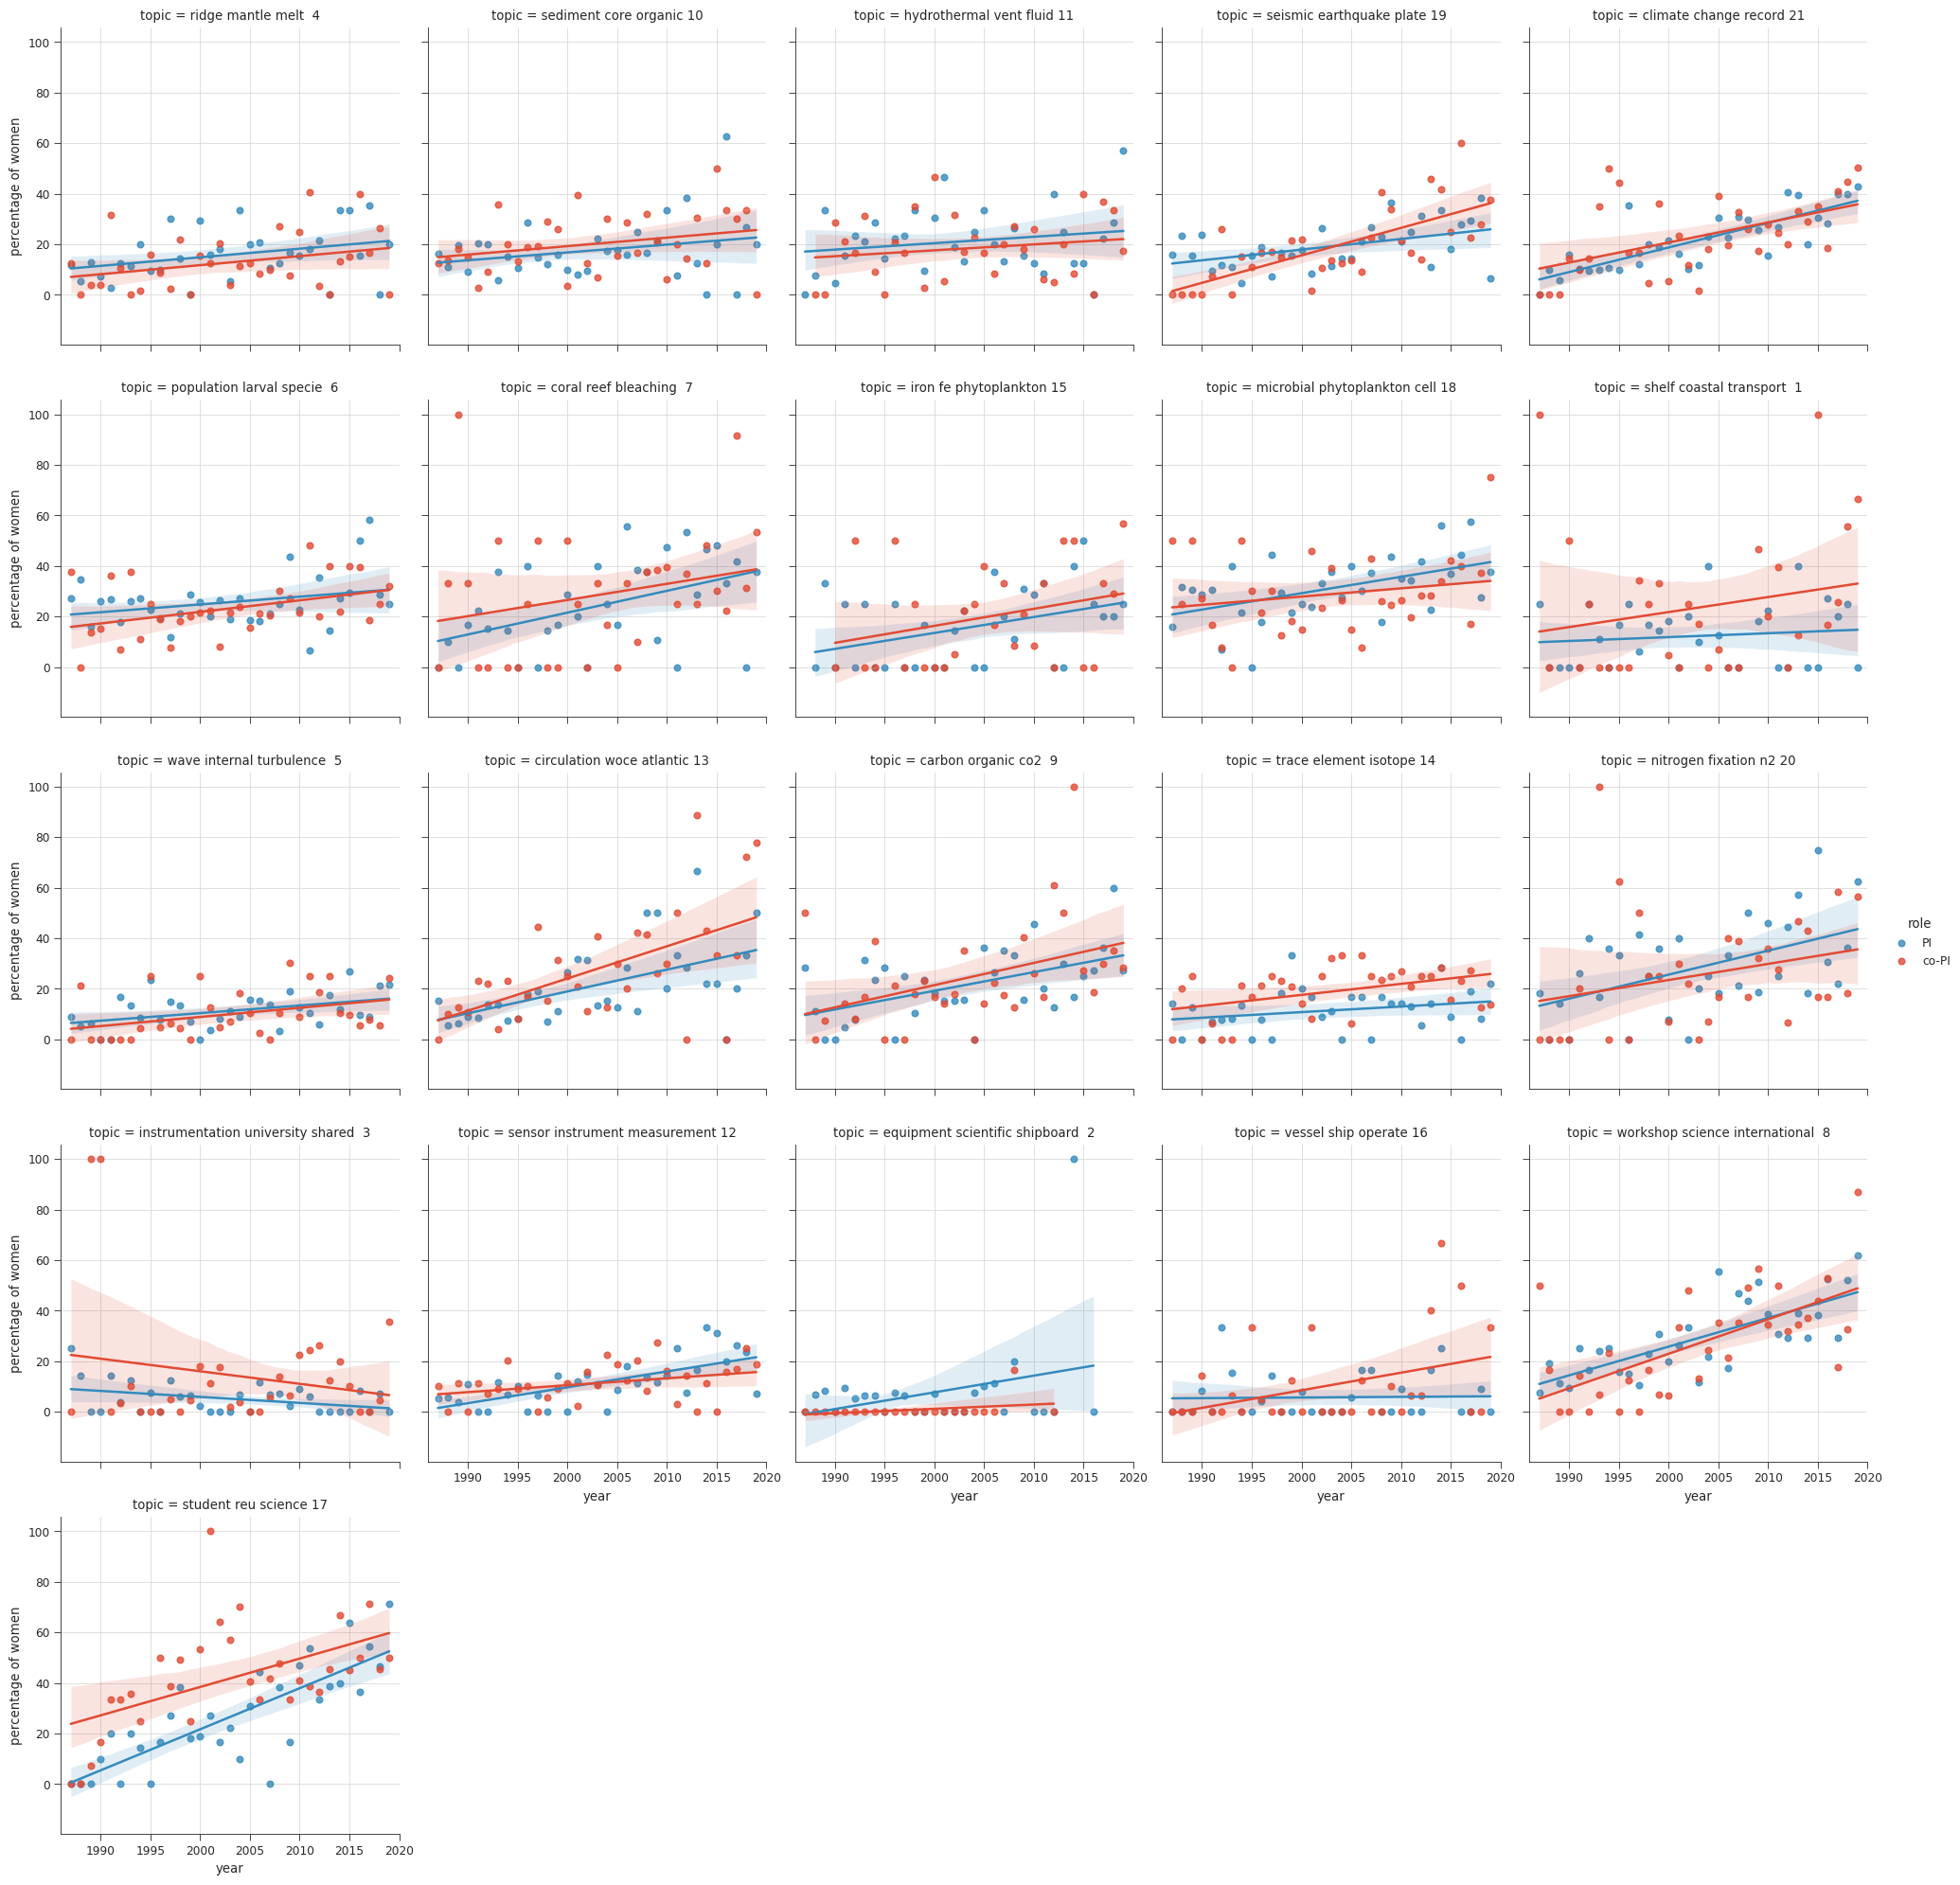

In [49]:
topic_map = {t+1:topic_names[t] for t in range(len(topic_names))}

df = awards.groupby(['topic','year','PI_gender'])['Abstract'].count().unstack()
pi_gender_by_topic = df.fillna(0).divide(df.sum(axis=1), axis=0)['female']
copi_gender_by_topic = awards.groupby(['topic', 'year'])['co-PI_female_frac'].mean()
female_pct_by_topic = pd.DataFrame({'PI': pi_gender_by_topic * 100, 'co-PI': copi_gender_by_topic * 100})
female_pct_by_topic = female_pct_by_topic.stack().reset_index().rename(columns={'level_2':'role', 0:'percentage'})
female_pct_by_topic['topic'] = female_pct_by_topic.topic.map(topic_map)
female_pct_by_topic

g = sns.lmplot(x='year', y='percentage', data=female_pct_by_topic, hue='role',
               col='topic', col_wrap=5, col_order=topic_names[topic_order-1], height=4)
_ = g.set(xlim=(1986,2020))
for n in [0, 5, 10, 15, 20]:
    _ = g.axes[n].set(ylabel='percentage of women')

The table below shows the linear regressions results.

In [50]:
female_pct = female_pct_by_topic.set_index(['topic','year','role']).unstack()
female_pct.columns = female_pct.columns.get_level_values(1)
params = []
for t in topic_names[topic_order-1]:
    lreg_pi, X = linreg(female_pct.loc[t].index, female_pct.loc[t,'PI'])
    lreg_copi, X = linreg(female_pct.loc[t].dropna().index, female_pct.loc[t,'co-PI'].dropna())
    params.append([lreg_pi.rsquared, lreg_pi.params[1], lreg_pi.pvalues[1],
                   lreg_copi.rsquared, lreg_copi.params[1], lreg_copi.pvalues[1]])

lr_stats = pd.DataFrame(np.array(params), index=topic_names[topic_order-1],
                        columns=[['PI','PI','PI','co-PI','co-PI','co-PI'],
                                 ['R^2','slope','p-value','R^2','slope','p-value']])
lr_stats.style.format('{:.3f}', subset=['PI','co-PI'])

### Differences in gender composition with respect to academic workforce

Using the linear trend for the combined data (PI and co_PI) as reference we compute anomalies that represent how female percentage/representation differs from that in the ocean sciences academic workforce. The figure below shows a stem plot of the anomalies for the identified research topic. The table shows the sum of the anomalies for each topic which is a metric of how each topic is performing relative to the academic workforce. Positive and negative values indicate that the topic is overperforming and underperforming female representation in the academic workforce, respectively.

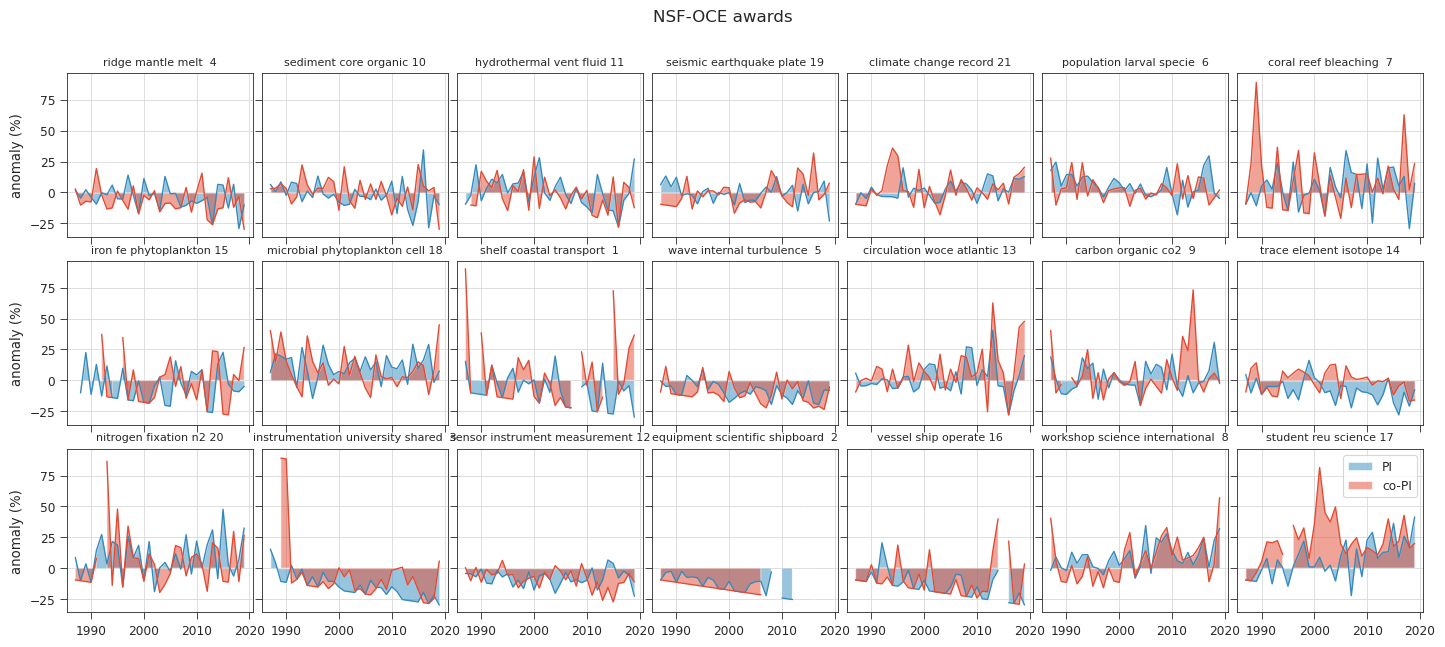

In [51]:
fig, axs = plt.subplots(3, 7, sharex=True, sharey=True, figsize=(17.5, 7))
fig.subplots_adjust(hspace=0.15, wspace=0.05)
params = []
for ax, t in zip(axs.ravel(), topic_names[topic_order-1]):
    anom = female_pct.loc[t] - df_ref
    _ = ax.fill_between(anom.index.values, anom.PI, alpha=0.5, label='PI')
    _ = ax.fill_between(anom.index.values, anom['co-PI'], alpha=0.5, label='co-PI')
    _ = ax.plot(anom.index.values, anom.PI, linewidth=1)
    _ = ax.plot(anom.index.values, anom['co-PI'], linewidth=1)           
    _ = ax.set_title(t, fontsize=8)
    params.append([anom.sum()[0], anom.sum()[1]])

for i in range(3):
    _ = axs[i,0].set_ylabel('anomaly (%)')

_ = ax.legend(loc='best')
_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

df_anom = pd.DataFrame(data=params, index=topic_names_r[topic_order-1], columns=['PI', 'co-PI'])
df_anom.columns.name = 'total sum'
df_anom.index.name = 'topics'
df_anom.style.format('{:.2f}')

## Award types

Types of awards and initiatives identified in the data include:

- Collaborative Research
- EAGER: EArly-concept Grant For Exploratory Research
- RAPID: Rapid Response Research
- REU: Research Experience for Undergraduates
- RUI: Research in Undergraduate Institutions
- SGER: Small Grants for Exploratory Research
- CAREER: Faculty Early Career Development
- CMG: Collaboration in Mathematical Geosciences
- POWRE: Professional Opportunities for Women in Research and Education

SGER is an older type of award (~2003) that seems to be a combination of EAGER and RAPID, but more like EAGER. Therefore we are grouping these two types of awards together as EAGER awards.

POWRE is an award type exclusive for women and there are only 13 awards of this type so it was removed from the analysis.

There are only CMG 20 awards with no women PIs, so it was also removed from the analysis.

### Number of awards

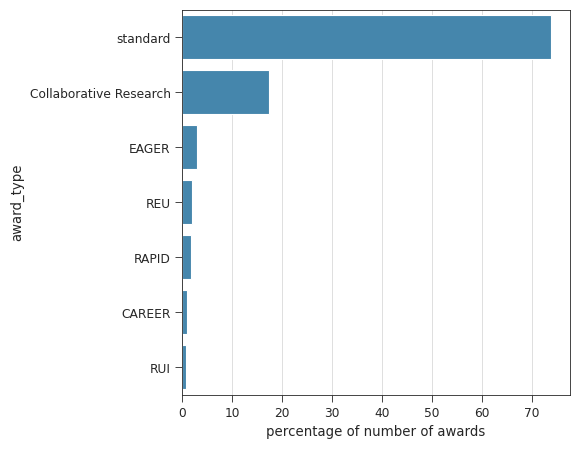

In [52]:
awards_clean = awards[awards.award_type!='CMG']
awards_clean = awards_clean[awards_clean.award_type!='POWRE']

atypes = pd.DataFrame({'number of awards': awards_clean.award_type.value_counts()})
atypes['percentage of total'] =  atypes['number of awards'] / len(awards) * 100
atypes['cum percentage of total'] = atypes['percentage of total'].cumsum()

fig, ax = plt.subplots()
_ = sns.barplot(data=atypes, y=atypes.index, x='percentage of total', orient='h', color='C0', ax=ax)
_ = ax.set(xlabel='percentage of number of awards')

atypes.style.format('{:.2f}', subset=['percentage of total','cum percentage of total'])

### Amount awarded

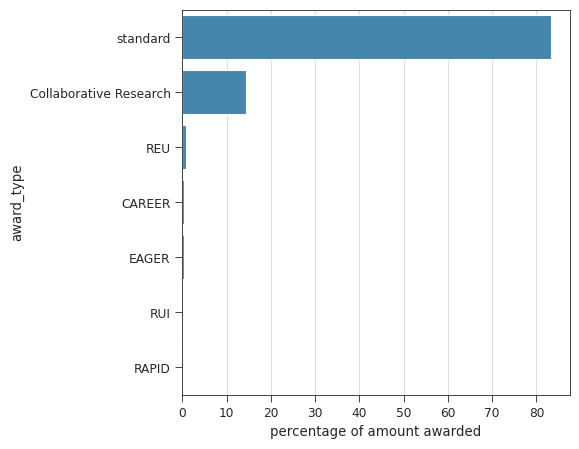

In [53]:
atype_amount = pd.DataFrame(
    {'amount awarded':
     awards_clean.groupby('award_type')['tot_amount_adjusted'].sum().sort_values(ascending=False)})
atype_amount['percentage of total'] = (atype_amount['amount awarded'] / awards['tot_amount_adjusted'].sum()
                                       * 100)
atype_amount['cum percentage of total'] = atype_amount['percentage of total'].cumsum()

fig, ax = plt.subplots()
_ = sns.barplot(data=atype_amount, y=atype_amount.index, x='percentage of total', orient='h', color='C0', ax=ax)
_ = ax.set(xlabel='percentage of amount awarded')

atype_amount.style.format('${0:,.2f}', subset='amount awarded')

Boxplot of award size by award type.

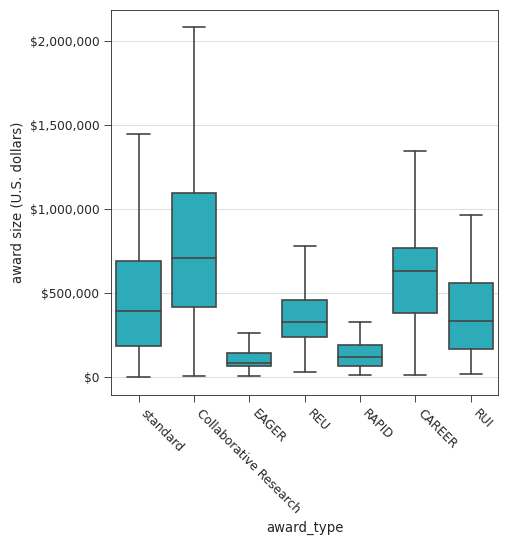

In [54]:
fig, ax = plt.subplots()
_ = sns.boxplot(data=awards_clean, x='award_type', y='tot_amount_adjusted', showfliers=False,
                order=atypes.index, color='C4', ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set_ylabel('award size (U.S. dollars)')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

Boxplot of award size by award type and PI gender.

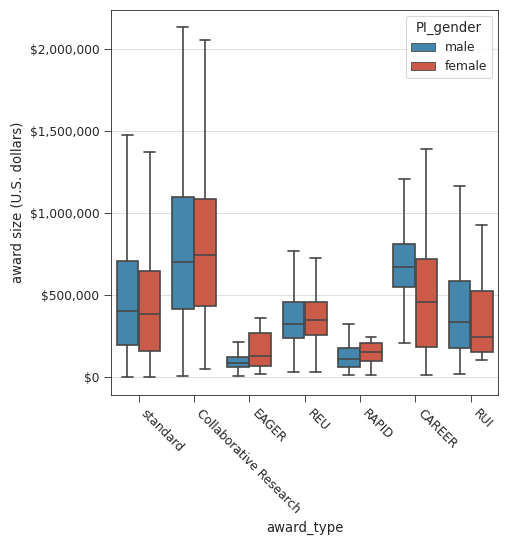

In [55]:
fig, ax = plt.subplots()
_ = sns.boxplot(data=awards_clean, x='award_type', y='tot_amount_adjusted', showfliers=False,
                order=atypes.index, hue='PI_gender', ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set_ylabel('award size (U.S. dollars)')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

The number and percentage of each award type in each year between 1987 2019. The annual amount awarded and percentage of annual amount awarded for each award type between 1987 2019.

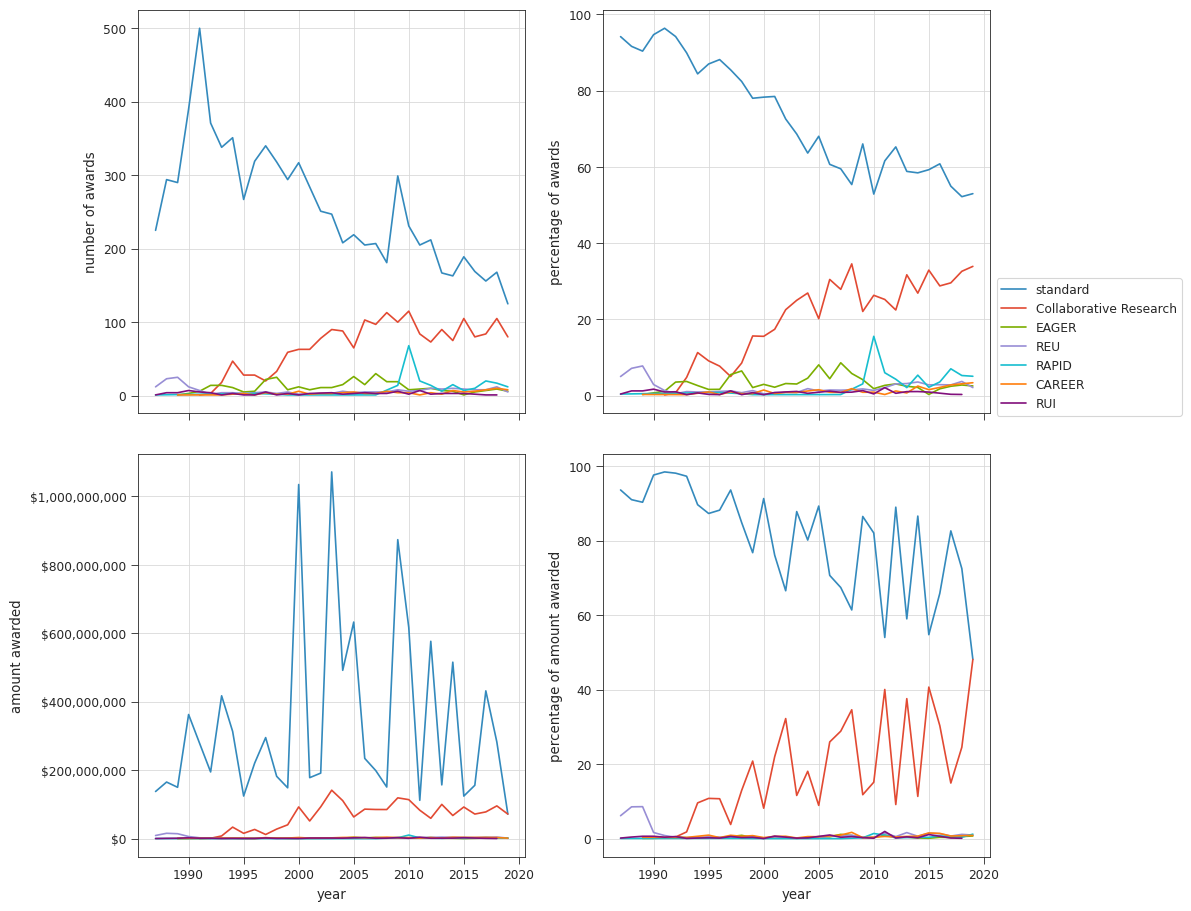

In [56]:
atype_year = pd.DataFrame({'number of awards': awards_clean.groupby(['year','award_type'])['Abstract'].count()})
atype_year['percentage of awards'] = atype_year['number of awards'].div(num_awards_per_year) * 100
atype_year['amount awarded'] = awards_clean.groupby(['year','award_type'])['tot_amount_adjusted'].sum()
atype_year['percentage of amount awarded'] = atype_year['amount awarded'].div(amount_awarded_per_year) * 100
atype_year = atype_year.reset_index()

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(11,11))
fig.subplots_adjust(hspace=0.1)
_ = sns.lineplot(data=atype_year, x='year', y='number of awards', hue='award_type', hue_order=atypes.index, ax=axs[0,0], legend=False)
_ = sns.lineplot(data=atype_year, x='year', y='percentage of awards', hue='award_type', hue_order=atypes.index, ax=axs[0,1])
_ = sns.lineplot(data=atype_year, x='year', y='amount awarded', hue='award_type', hue_order=atypes.index, ax=axs[1,0], legend=False)
_ = sns.lineplot(data=atype_year, x='year', y='percentage of amount awarded', hue='award_type', hue_order=atypes.index, ax=axs[1,1], legend=False)
_ = axs[1,0].yaxis.set_major_formatter(fmt)
_ = axs[0,1].legend(loc='upper left',bbox_to_anchor=(1, 0.35))

### Frequency distribution of award types by PI gender

The table and figure below show the distribution (relative proportion) of different award types by PI gender. They show how the awards from each gender (PI) are distributed across the different award types.

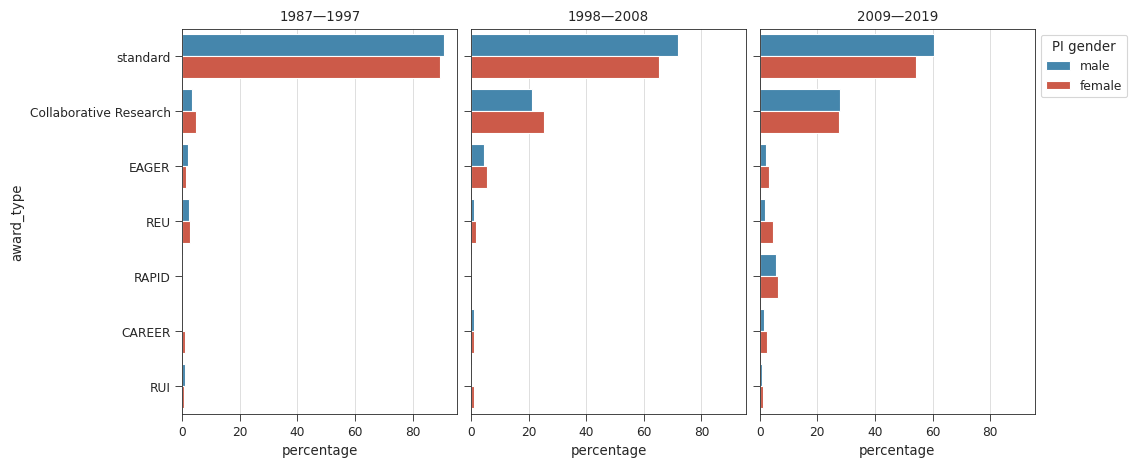

In [57]:
awards_clean_1 = awards_clean[awards_clean.year<1998]                              # 1987-1997
awards_clean_2 = awards_clean[(awards_clean.year>1997) & (awards_clean.year<2009)] # 1998-2008
awards_clean_3 = awards_clean[awards_clean.year>2008]                              # 2009-2019

dflist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,5))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [awards_clean_1, awards_clean_2, awards_clean_3], titles):
    df1 = df.groupby(['award_type','PI_gender'])['Abstract'].count()
    df2 = df.groupby(['PI_gender'])['Abstract'].count()
    df_pct = (df1.div(df2, axis=0) * 100).reindex(atypes.index, level='award_type')
    dflist.append(df_pct.unstack().fillna(0))
    df_pct = df_pct.rename('percentage').reset_index()
    _ = sns.barplot(data=df_pct, y='award_type', x='percentage', orient='h', hue='PI_gender',
                    hue_order=['male','female'], order=atypes.index, ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t)

for n in range(1,3):
    _ = axs[n].set_ylabel('')
    
_ = ax.legend(title='PI gender',loc='upper left', bbox_to_anchor=(1, 1))

df_atype = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1)
df_atype.style.format('{:.2f}')

### Gender composition across award types

PI gender percentage across award types.

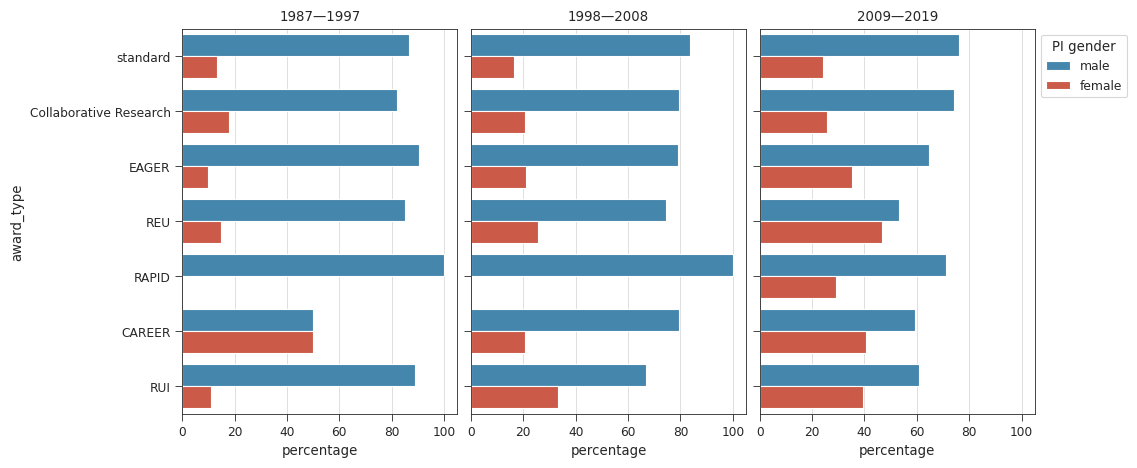

In [58]:
dflist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,5))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [awards_clean_1, awards_clean_2, awards_clean_3], titles):
    df1 = df.groupby(['award_type','PI_gender'])['Abstract'].count()
    df2 = df1.unstack().sum(axis=1)
    df_pct = df1.divide(df2, axis=0) * 100 # fraction -> percentage
    df_pct = df_pct.reindex(atypes.index, level=0)
    dflist.append(df_pct.unstack().fillna(0))
    df_pct = df_pct.rename('percentage').reset_index()
    _ = sns.barplot(data=df_pct, y='award_type', x='percentage', hue='PI_gender',
                    hue_order=['male','female'], order=atypes.index, ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t, xlabel='percentage')    

for n in range(1,3):
    _ = axs[n].set_ylabel('')
    
_ = ax.legend(title='PI gender',loc='upper left', bbox_to_anchor=(1, 1))

by_atype_pi = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1)
by_atype_pi.style.format('{:.2f}')

co-PI gender percentage across award types.

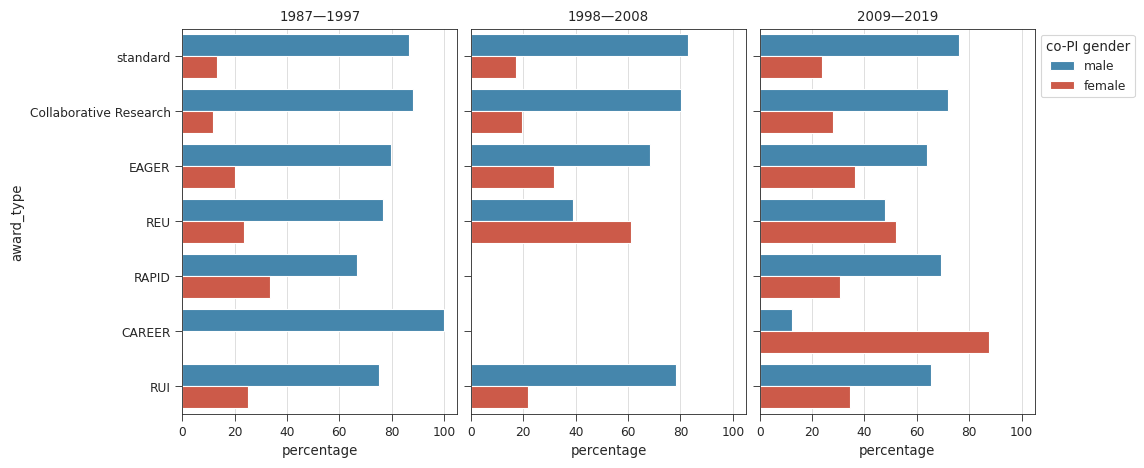

In [62]:
dflist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,5))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [awards_clean_1, awards_clean_2, awards_clean_3], titles):
    df_pct = pd.DataFrame({'female': df.groupby(['award_type'])['co-PI_female_pct'].mean()})
    df_pct['male'] = 100 - df_pct.female
    df_pct.columns.name = 'co-PI gender'
    df_pct = df_pct.reindex(atypes.index).fillna(0)
    dflist.append(df_pct)
    df_pct = df_pct.stack().reset_index().rename(columns={'level_0':'award type', 0:'percentage'})
    _ = sns.barplot(data=df_pct, y='award_type', x='percentage', hue='co-PI gender',
                    hue_order=['male','female'], order=atypes.index, ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t, xlabel='percentage')

for n in range(1,3):
    _ = axs[n].set_ylabel('')

ax.legend(title='co-PI gender',loc='upper left',bbox_to_anchor=(1, 1))

by_atype_copi = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1)
by_atype_copi.style.format('{:.2f}')

### Changes in gender composition across award types

The figure below shows time series of the annual percentage of female PIs and co-PIs for each NSF-OCE award types. Solid lines represent the linear regression fit and points represent the individual years. The table shows the linear regressions results.

Except for *Collaborative Research* and *standard* awards, the number of awards per year in each award type is small, therefore the variability is high. Many award types don't have enough points to fit a linear regression.

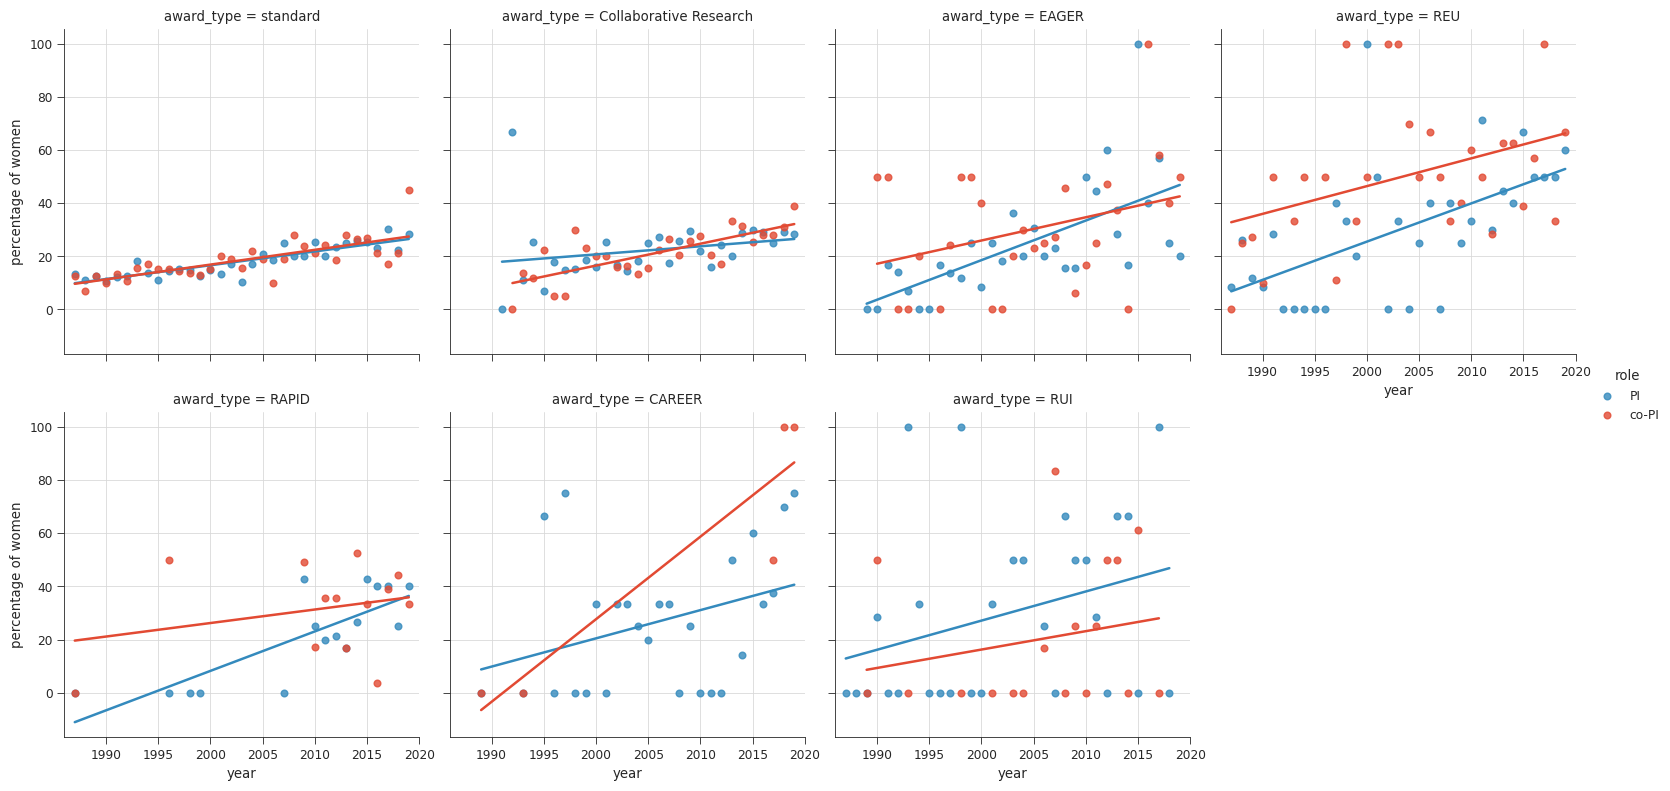

In [63]:
# female fraction of PIs
df = awards_clean.groupby(['award_type','year','PI_gender'])['Abstract'].count().unstack()
pi_female_pct_by_atype = df.fillna(0).divide(df.sum(axis=1), axis=0)['female'] * 100
# female fraction of co-PIs
copi_female_pct_by_atype = awards_clean.groupby(['award_type','year'])['co-PI_female_frac'].mean() * 100
# combined data
female_pct_by_atype = pd.DataFrame({'PI':pi_female_pct_by_atype, 'co-PI':copi_female_pct_by_atype})
female_pct_by_atype = female_pct_by_atype.stack().reset_index().rename(columns={'level_2':'role',0:'percentage'})
# plot linear regression
g = sns.lmplot(x='year', y='percentage', data=female_pct_by_atype, hue='role', ci=None,
               col='award_type', col_wrap=4, col_order=atypes.index, height=4)
_ = g.set(xlim=(1986,2020))
for n in [0, 4]:
    _ = g.axes[n].set(ylabel='percentage of women')

female_pct = female_pct_by_atype.set_index(['award_type','year','role']).unstack()
female_pct.columns = female_pct.columns.get_level_values(1)
params = []
for a in atypes.index:
    lreg_pi, X = linreg(female_pct.loc[a].index, female_pct.loc[a,'PI'])
    lreg_copi, X = linreg(female_pct.loc[a].dropna().index, female_pct.loc[a,'co-PI'].dropna())
    params.append([lreg_pi.rsquared, lreg_pi.params[1], lreg_pi.pvalues[1],
                   lreg_copi.rsquared, lreg_copi.params[1], lreg_copi.pvalues[1]])

lr_stats = pd.DataFrame(np.array(params), index=atypes.index,
                        columns=[['PI','PI','PI','co-PI','co-PI','co-PI'],
                                 ['R^2','slope','p-value','R^2','slope','p-value']])
lr_stats.style.format('{:.3f}', subset=['PI','co-PI'])

### Differences in gender composition with respect to academic workforce

Using the linear trend for the combined data (PI and co_PI) as reference we compute anomalies that represent how female percentage/representation differs from that in the ocean sciences academic workforce. The figure below shows a stem plot of the anomalies for the different award type. The table shows the sum of the anomalies for each award type which is a metric of how each award type is performing relative to the academic workforce. Positive and negative values indicate that the award type is overperforming and underperforming female representation in the academic workforce, respectively.

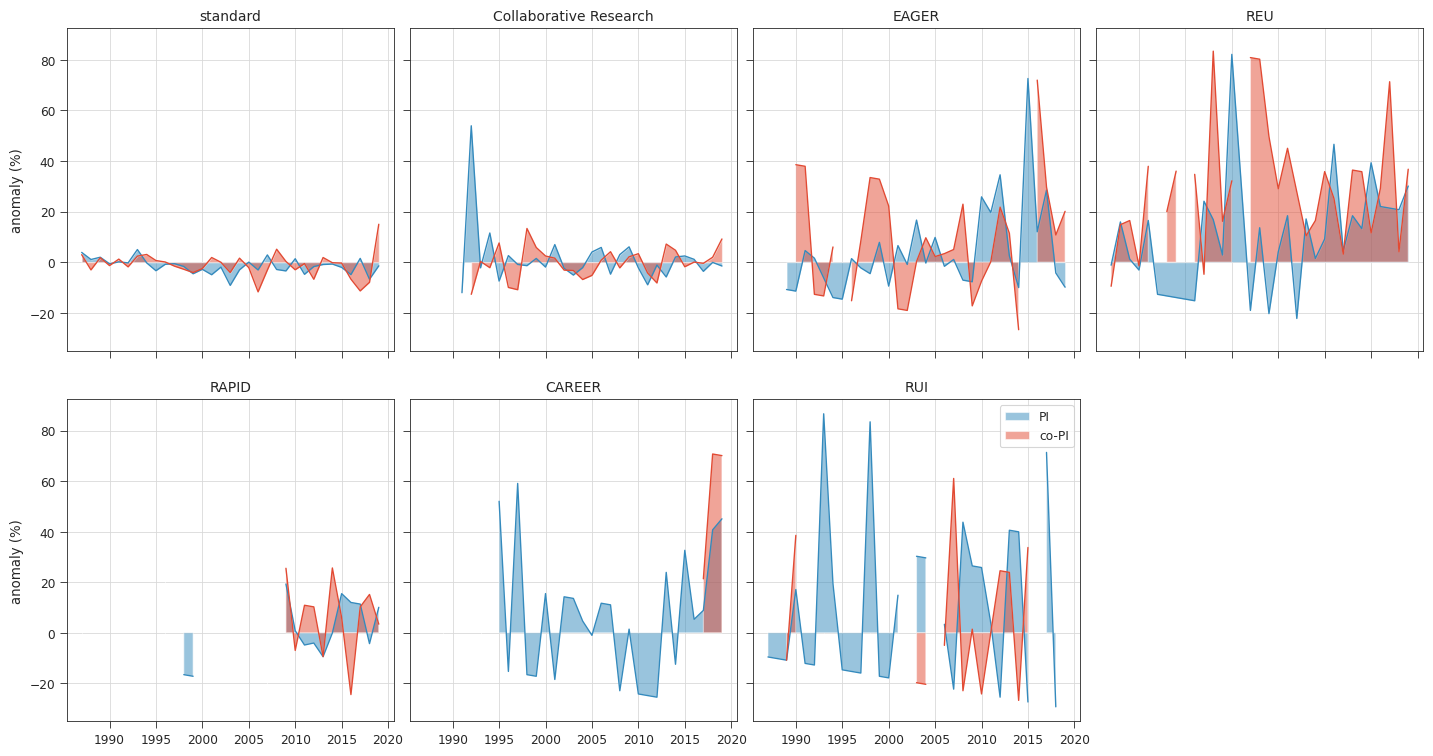

In [64]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(17.5, 9))
fig.subplots_adjust(hspace=0.15, wspace=0.05)
fig.delaxes(axs[1,3])
params = []
for ax, atype in zip(axs.ravel(), atypes.index):
    anom = female_pct.loc[atype] - df_ref
    _ = ax.fill_between(anom.index.values, anom.PI, alpha=0.5, label='PI')
    _ = ax.fill_between(anom.index.values, anom['co-PI'], alpha=0.5, label='co-PI')
    _ = ax.plot(anom.index.values, anom.PI, linewidth=1)
    _ = ax.plot(anom.index.values, anom['co-PI'], linewidth=1)           
    _ = ax.set_title(atype, fontsize=10)
    params.append([anom.sum()[0], anom.sum()[1]])

for i in range(2):
    _ = axs[i,0].set_ylabel('anomaly (%)')

_ = ax.legend(loc='best')

df_anom = pd.DataFrame(data=params, index=atypes.index, columns=['PI', 'co-PI'])
df_anom.columns.name = 'total sum'
df_anom.style.format('{:.2f}')